# Imports

In [1]:
import yfinance        as yf
import seaborn         as sns
import numpy           as np
import pandas          as pd
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, mean_squared_error

from matplotlib              import pyplot as plt
from pandas_datareader       import data   as pdr
from IPython.core.display    import HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [3]:
yf.pdr_override()

In [4]:
start = '2000-01-01'
#end = '2019-12-31'
end = '2021-12-31'

data = pdr.get_data_yahoo( '^GSPC', start=start, end=end )

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000


# Data Description

In [7]:
df2 = data.copy()

In [8]:
df2.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Times Series Visualization

In [9]:
df3 = df2.copy()

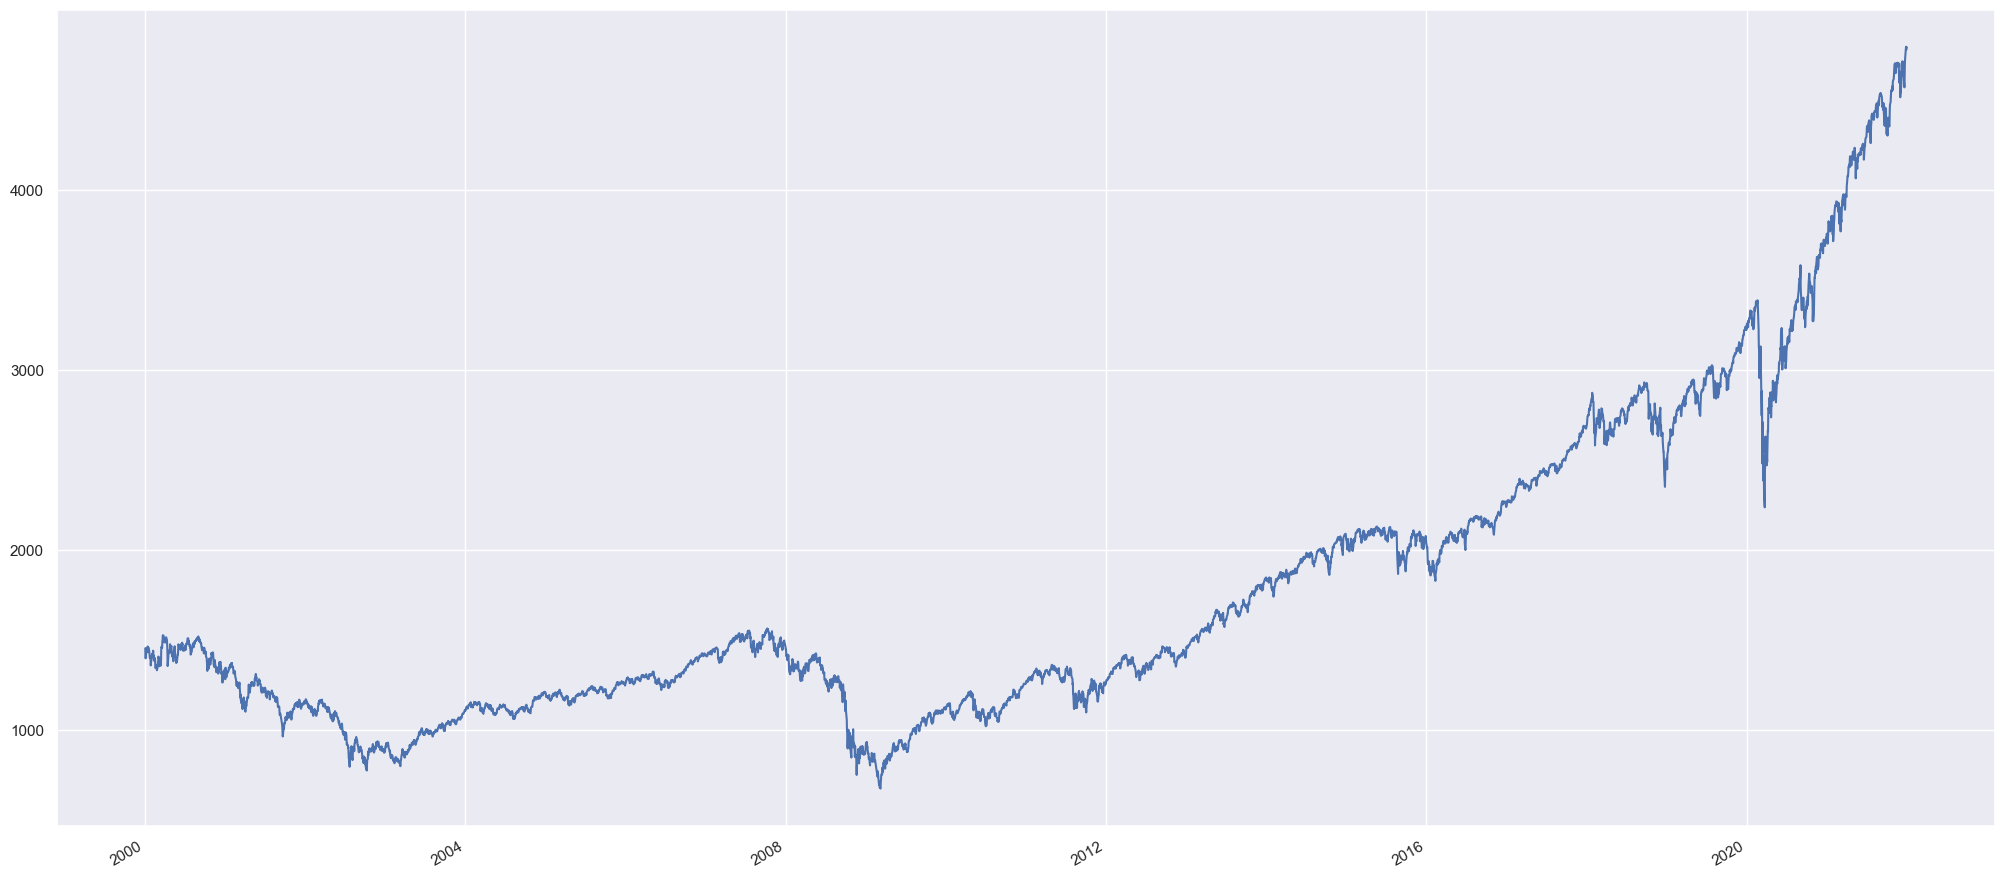

In [10]:
df3['Close'].plot()
#plt.title( 'Gráfico da Série S&P 500' );
plt.xlabel( '' );

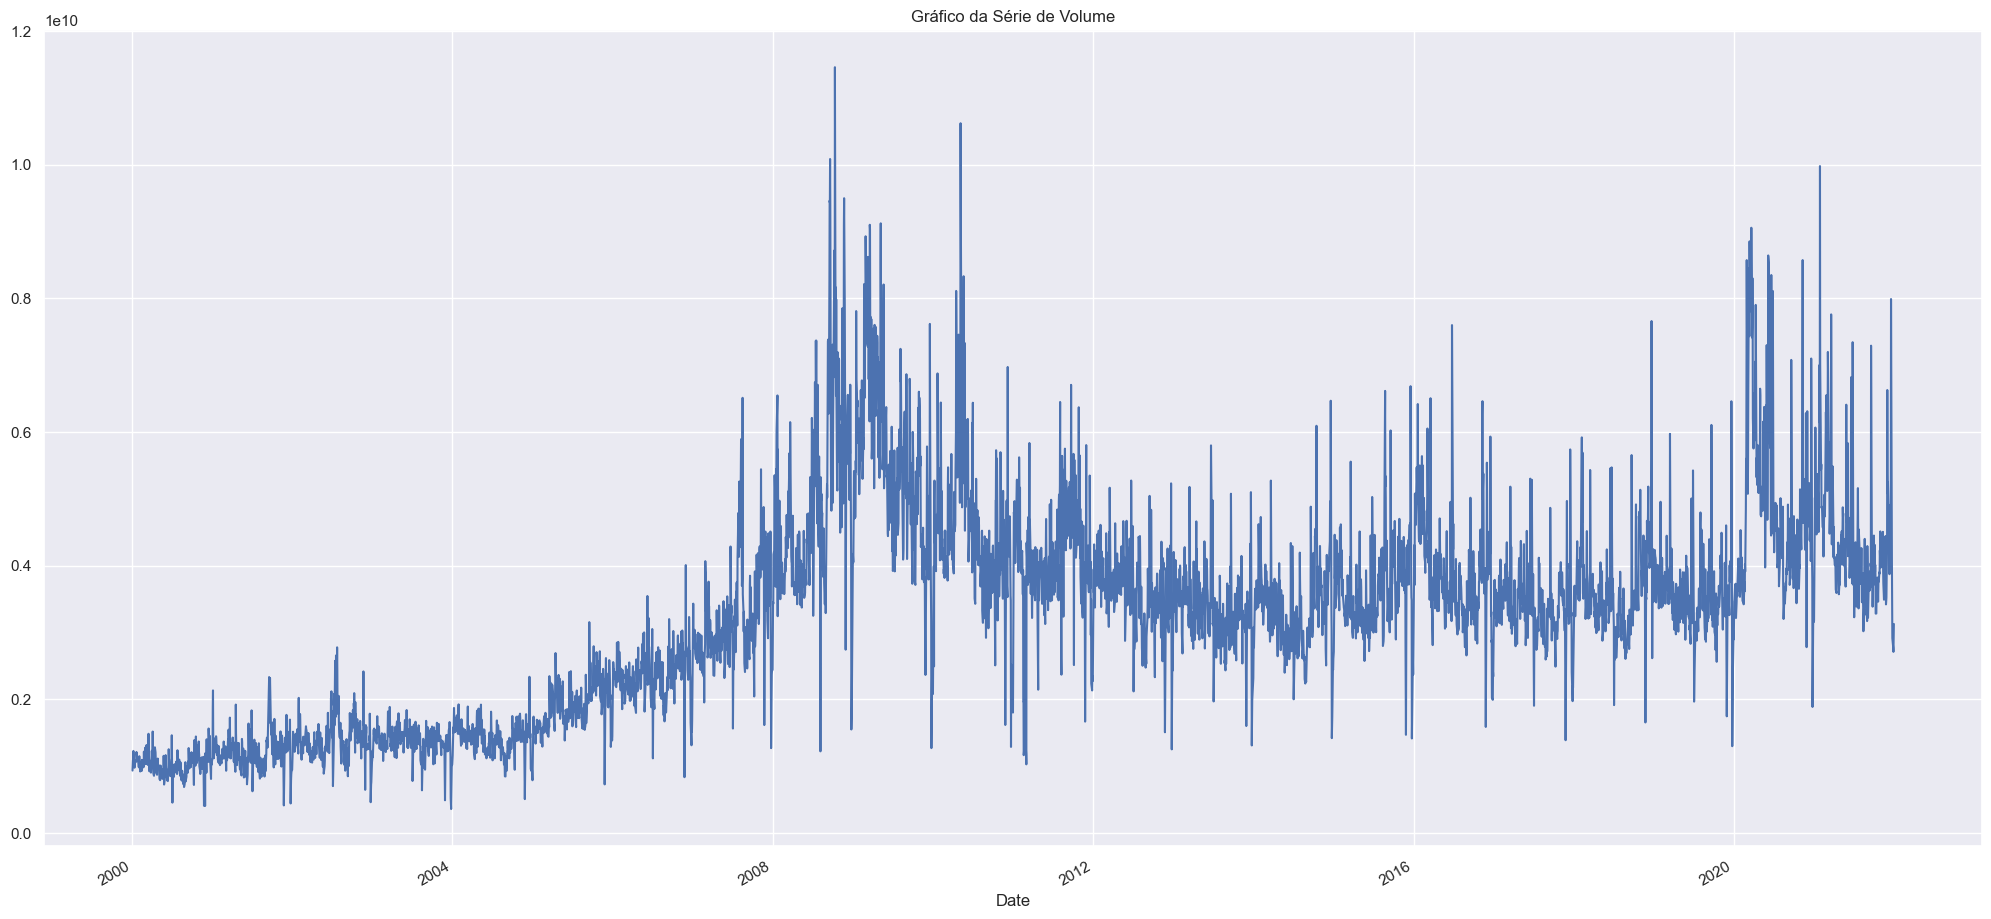

In [11]:
df3['Volume'].plot();
plt.title( 'Gráfico da Série de Volume' );

# Exploratory Data Analysis

In [12]:
df4 = df3.copy()

In [13]:
df4.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5.535000e+03
mean,1772.102924,1782.233612,1761.197519,1772.378729,1772.378729,3.237908e+09
std,856.734841,859.780494,853.671921,857.084851,857.084851,1.521928e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1173.785034,1182.119995,1166.144958,1173.805054,1173.805054,1.855095e+09
50%,1409.119995,1415.890015,1399.250000,1409.119995,1409.119995,3.349090e+09
75%,2123.404907,2130.660034,2115.059937,2125.030029,2125.030029,4.075415e+09
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,1.145623e+10


In [14]:
# lag de X periodos

periodos = 1

# lag positivo de X periodos
df4['Lag_P1'] = df4['Close'].shift( periodos )

In [15]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951


In [16]:
# Dummy para saber se o dia atual é Alta(1) ou Baixa(0)

df4['High_Low'] = np.where( df4['Close'] > df4['Lag_P1'], 1, 0 )

In [17]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1


In [18]:
df4['High_Low'].mean()

0.538572719060524

In [19]:
# Calculando o Retorno

df4['Retorno'] = df4['Close'].pct_change( periodos )

In [20]:
df4.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


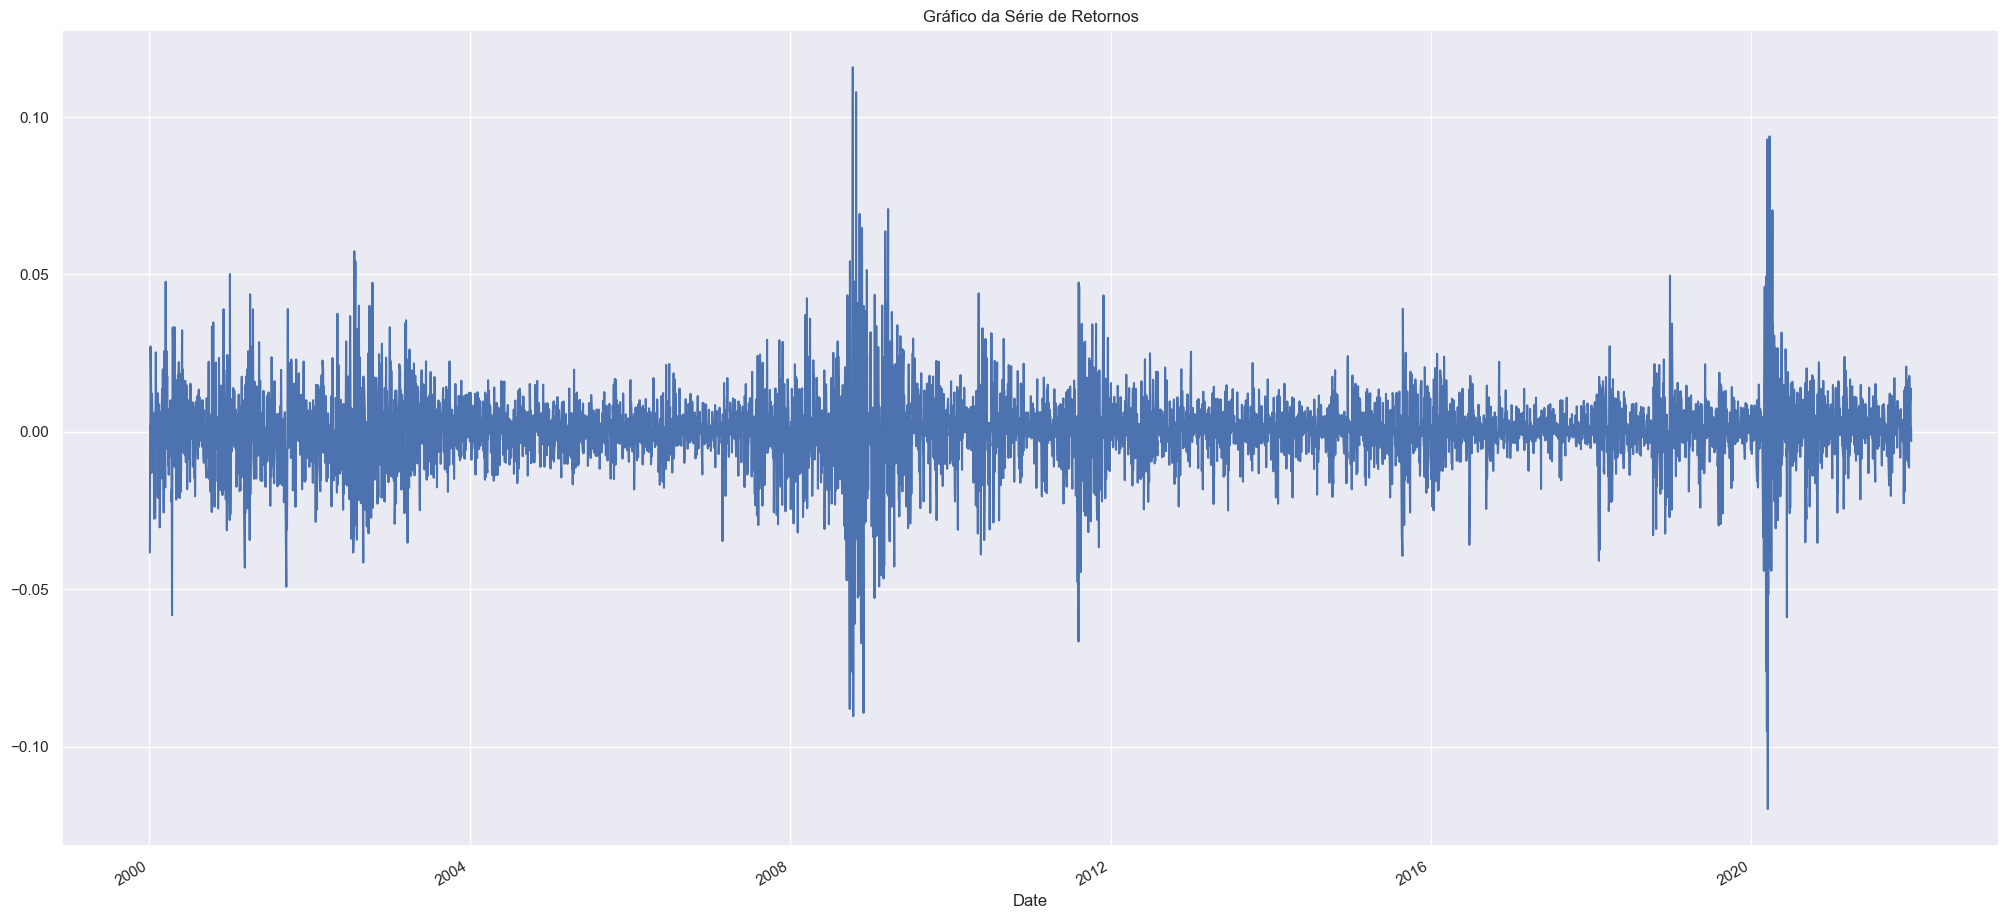

In [21]:
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

C:\Users\lucas\AppData\Local\Temp\ipykernel_5860\3695061061.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


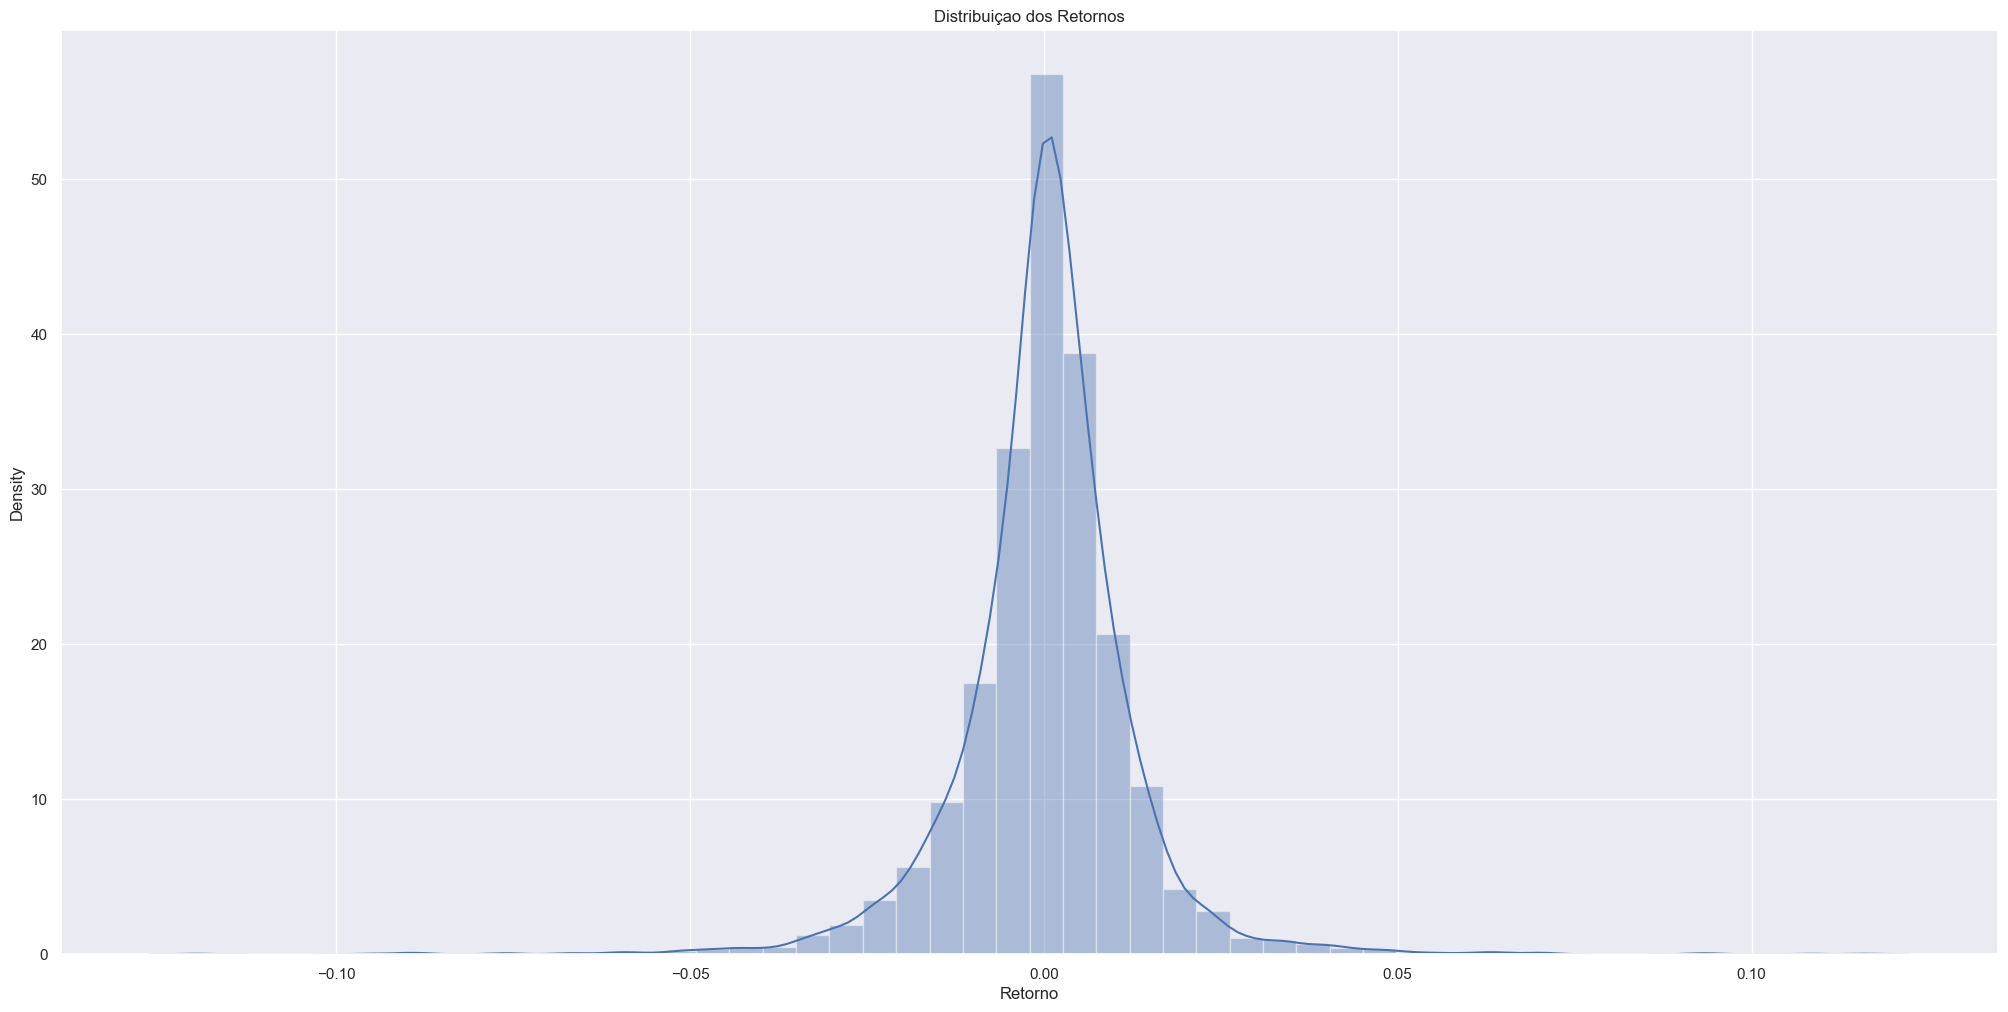

In [22]:
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

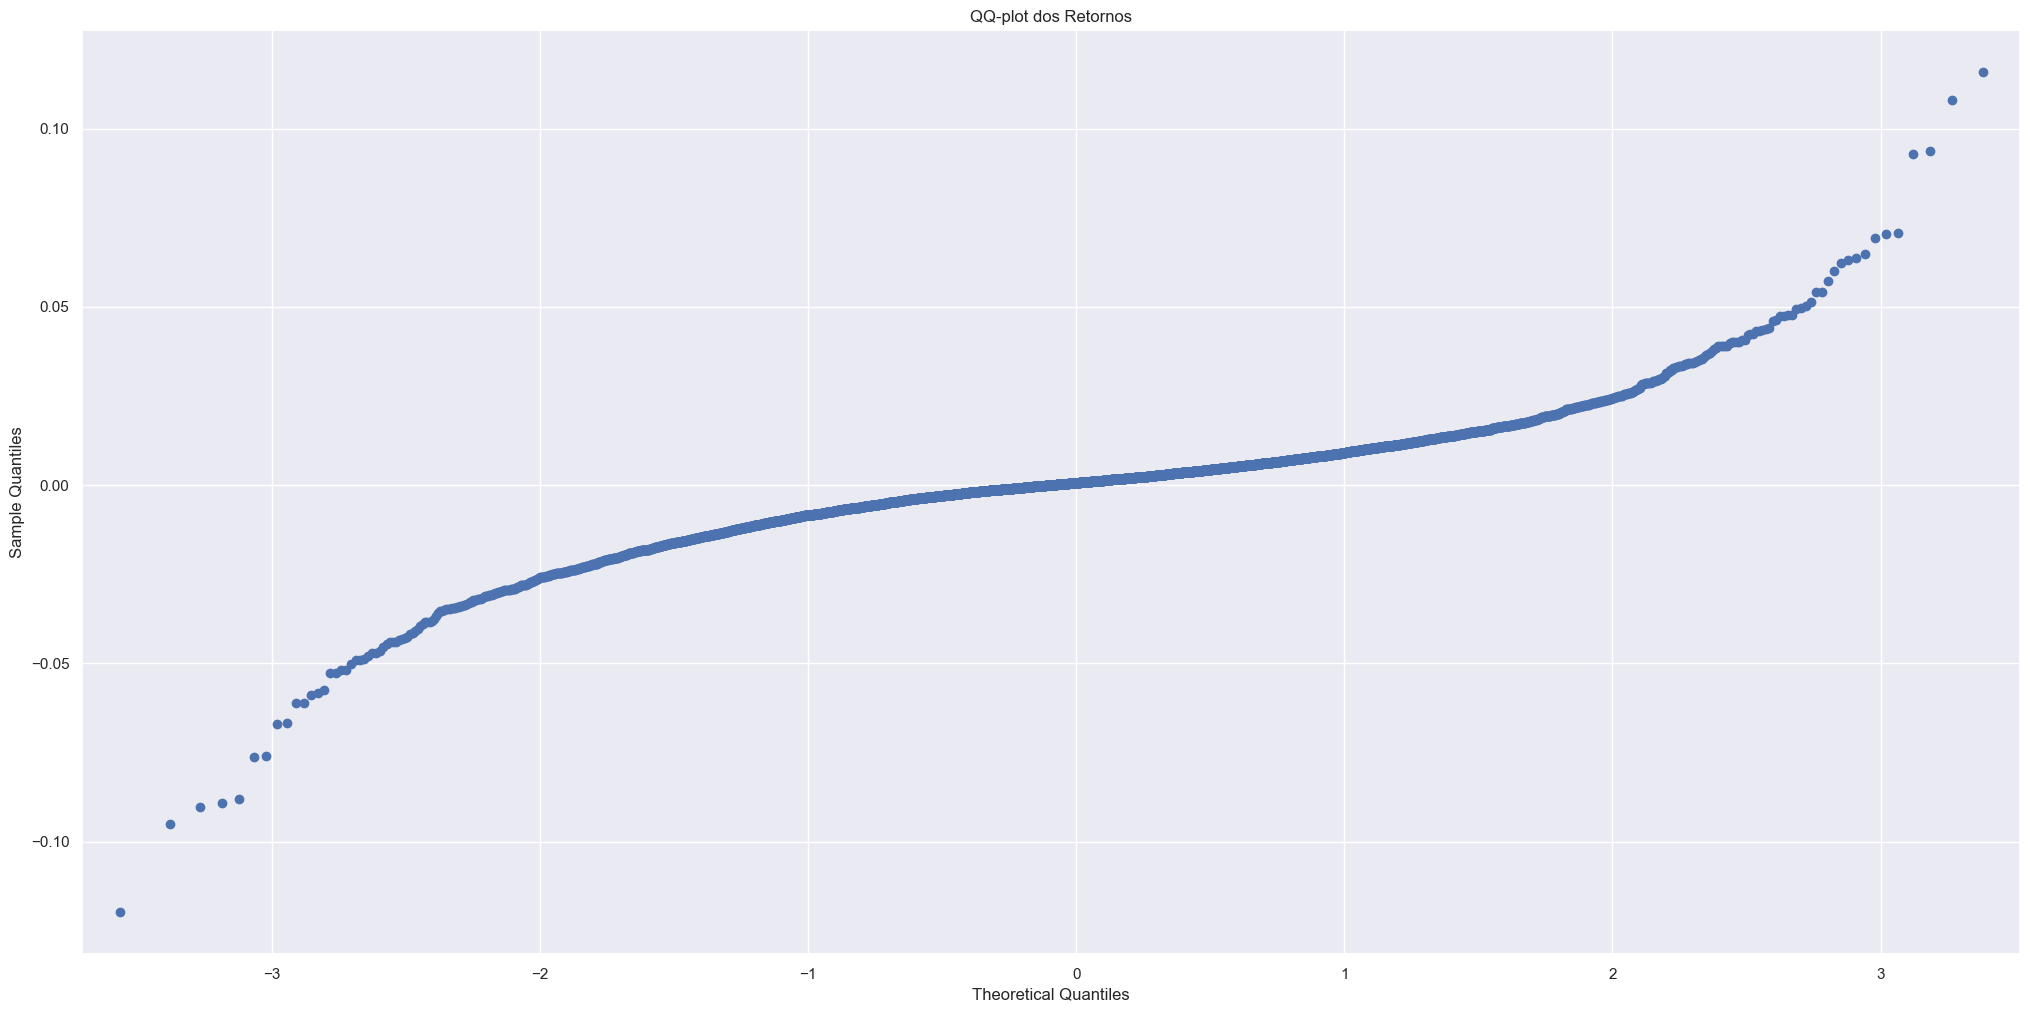

In [23]:
sm.qqplot( df4['Retorno'] )
plt.title( 'QQ-plot dos Retornos' );

Consolidando os gráficos da série histórica, série de retornos, distribuição dos retornos e qq-plot em uma mesma imagem.

C:\Users\lucas\AppData\Local\Temp\ipykernel_5860\3273338487.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['Retorno'],


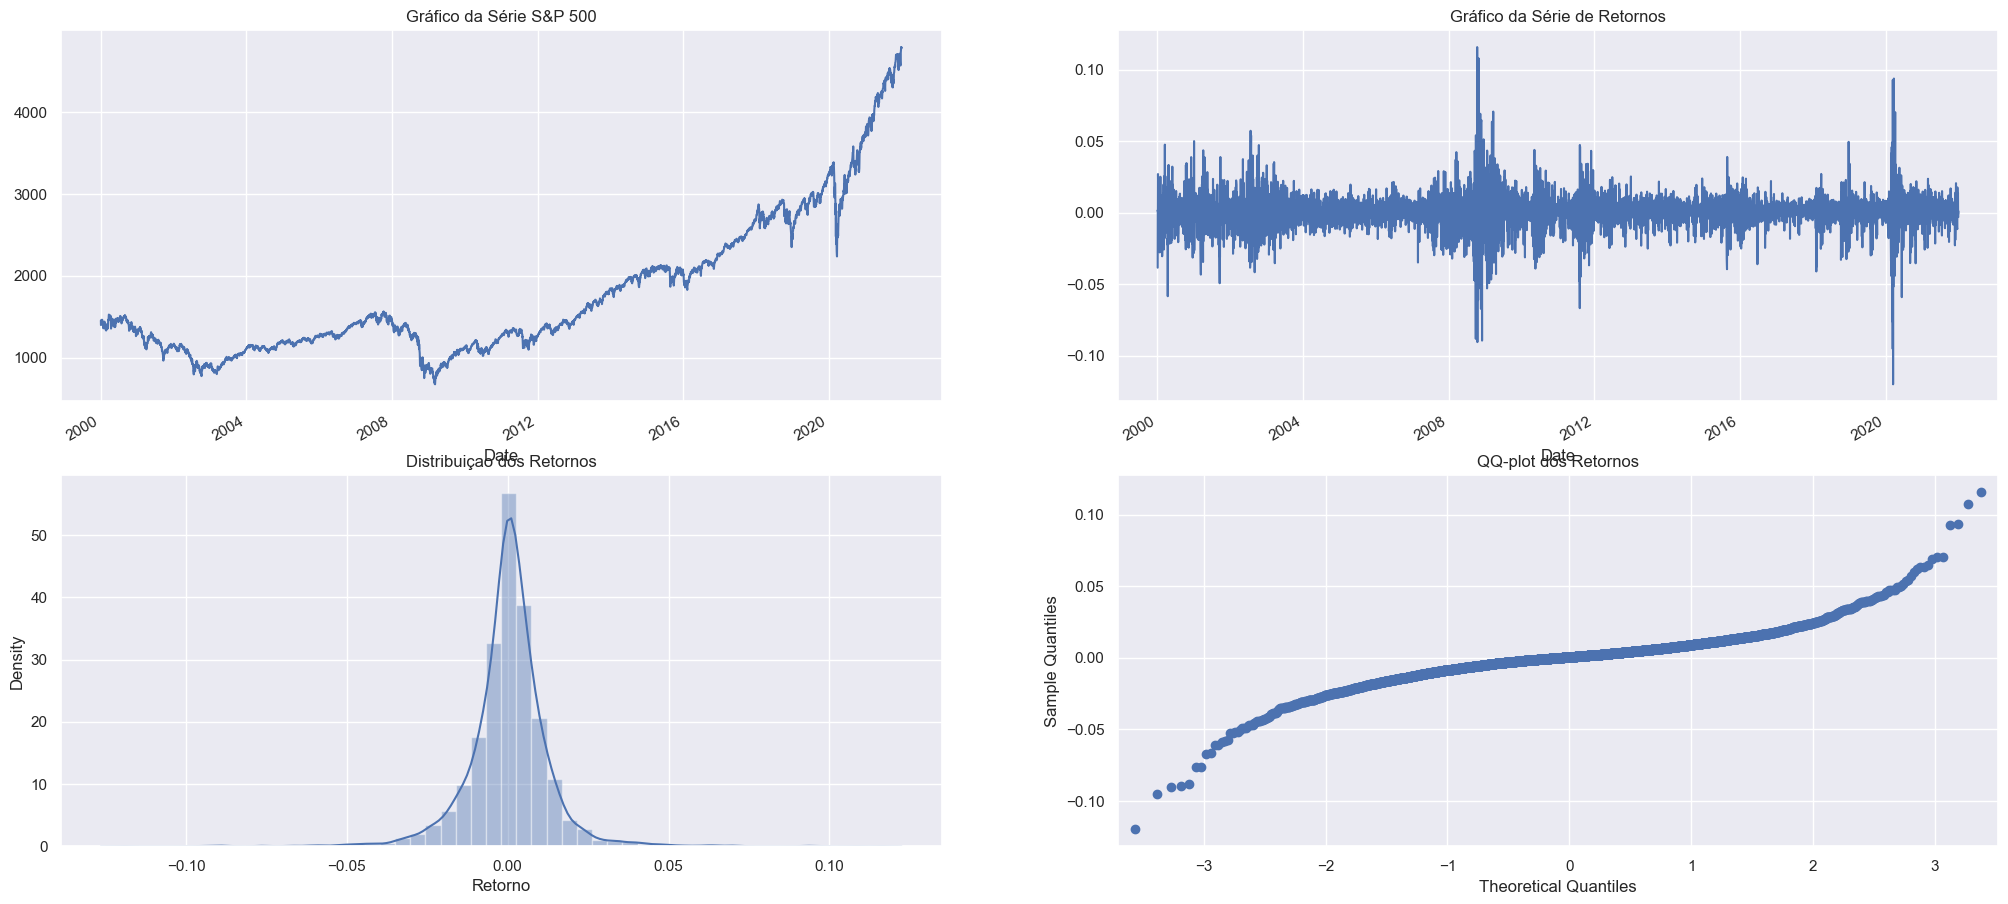

In [24]:
plt.subplot( 2, 2, 1 )
df3['Close'].plot()
plt.title( 'Gráfico da Série S&P 500' );

plt.subplot( 2, 2, 2 )
df4['Retorno'].plot()
plt.title( 'Gráfico da Série de Retornos' );

plt.subplot( 2, 2, 3 )
sns.distplot( df4['Retorno'], 
              bins = 50,
              kde=True
            )
plt.title( 'Distribuiçao dos Retornos' );

#plt.subplot( 2, 2, 4 )
sm.qqplot( df4['Retorno'], ax=plt.subplot( 2, 2, 4 ) ) 
plt.title( 'QQ-plot dos Retornos' );

In [25]:
df4['Retorno'].describe()

count    5534.000000
mean        0.000292
std         0.012370
min        -0.119841
25%        -0.004695
50%         0.000639
75%         0.005830
max         0.115800
Name: Retorno, dtype: float64

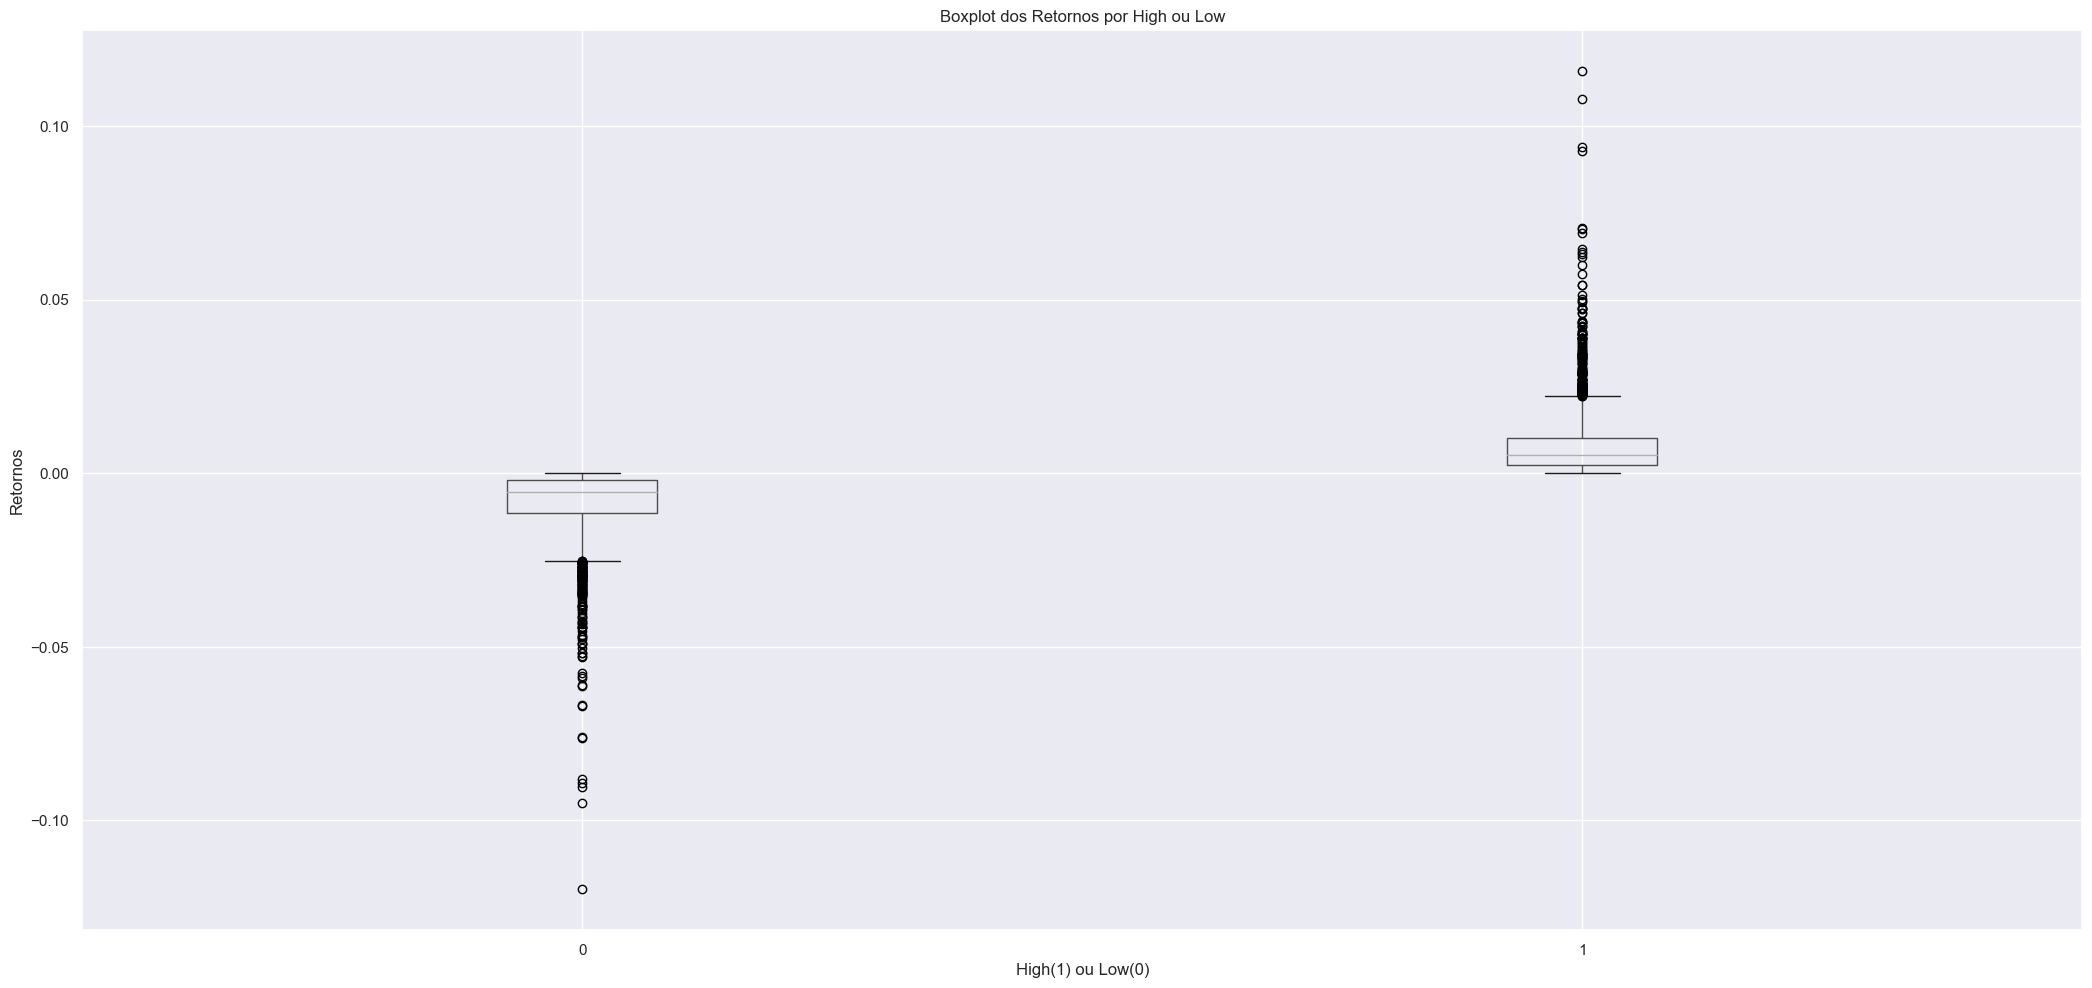

In [26]:
df4.boxplot( by='High_Low', column=['Retorno'], grid = True ) 
title = 'Boxplot dos Retornos por High ou Low'
plt.title( title )
plt.suptitle( '' ) # para eliminar o titulo padrao do boxplot do pandas
plt.ylabel( 'Retornos' )
plt.xlabel( 'High(1) ou Low(0)' )
plt.show();

# Feature Engineering

In [97]:
df5 = df4.copy()

In [98]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090


## Creating targets and features

In [99]:
# Adicionando um alvo

df5["Alvo1"] = df5["Retorno"].shift( -periodos )
df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0 , 1, 0 )

#df5["Alvo1_Bin"] = np.where( df5["Alvo1"] > 0.0025 , 1, np.where( df5["Alvo1"] < -0.0025 , -1, 0 ) )

In [100]:
df5.head()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin
Date,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,0,NaN,-0.038345,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,0,-0.038345,0.001922,1
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,1,0.001922,0.000956,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,1,0.000956,0.027090,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,1,0.027090,0.011190,1


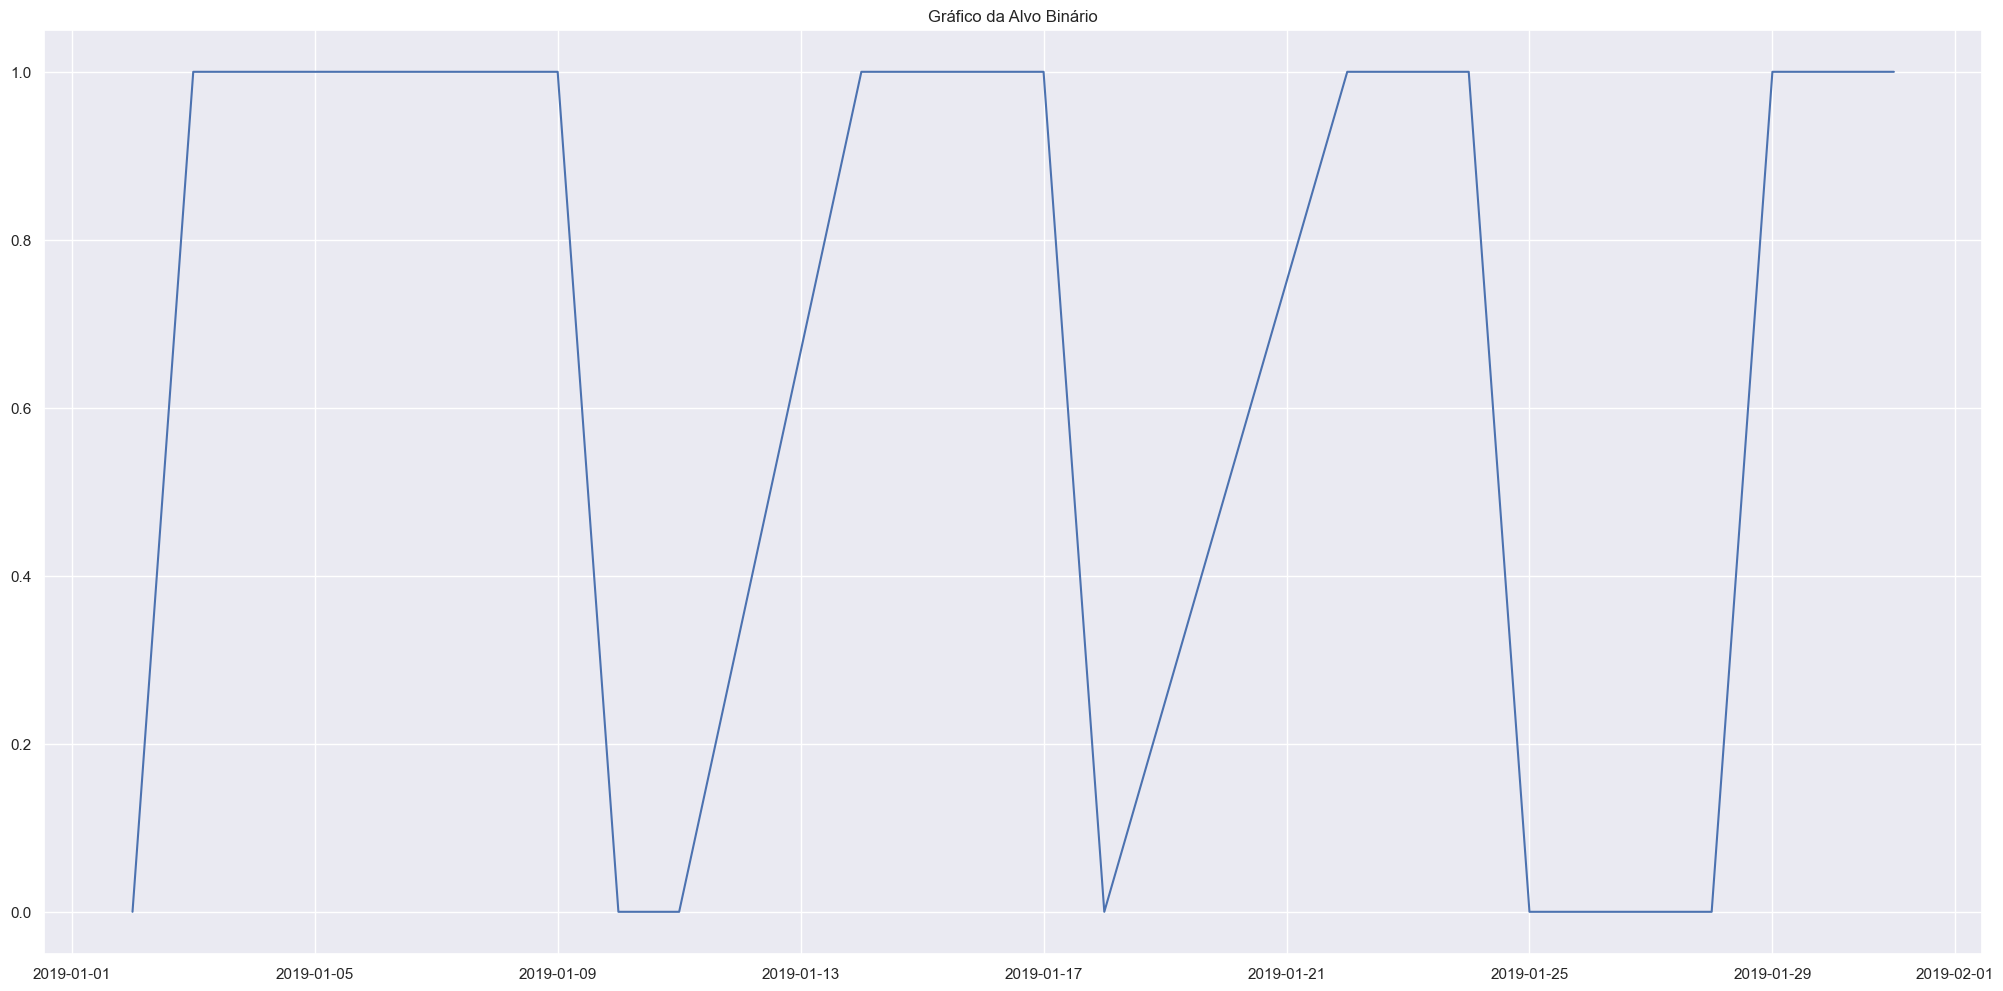

In [109]:
df_alvo = df5['Alvo1_Bin']

plt.plot(df_alvo['2019-01'])
plt.title( 'Gráfico da Alvo Binário' );

In [31]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df5["std5"] = df5["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df5["std10"] = df5["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df5["std15"] = df5["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df5["prop"] = (df5["Close"]-df5["Open"])/(df5["High"]-df5["Low"])

# Direçao do dia atual
df5["dir_D"] = np.where(df5['Close'] > df5['Open'] , '1', '0')

# Direçao D-1
df5["dir_D-1"] = df5["dir_D"].shift(1)

# Direçao D-2
df5["dir_D-2"] = df5["dir_D"].shift(2)

# Direçao D-3
df5["dir_D-3"] = df5["dir_D"].shift(3)

# Media Movel de 15 dias std5
df5["mm_std5"] = df5["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std10"] = df5["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df5["mm_std15"] = df5["std15"].rolling(15).mean()

# RSL std5
df5["RSL_std5"] = df5["std5"]/df5["mm_std5"]

# RSL std10
df5["RSL_std10"] = df5["std10"]/df5["mm_std10"]

# RSL std15
df5["RSL_std15"] = df5["std15"]/df5["mm_std15"]

In [32]:
# Construção das novas variáveis indicados pelo Viola
df5['Variation'] = df5['Close'].diff()
df5 = df5[1:]
df5['Gain'] = np.where(df5['Variation'] > 0, df5['Variation'], 0) 
df5['Loss'] = np.where(df5['Variation'] < 0, df5['Variation'], 0)
n = 14
simple_avg_gain = df5['Gain'].rolling(n).mean()
simple_avg_loss = df5['Loss'].abs().rolling(n).mean()

# start off of simple average series
classic_avg_gain = simple_avg_gain.copy()
classic_avg_loss = simple_avg_loss.copy()

# iterate over the new series but only change values after the nth element
for i in range(n, len(classic_avg_gain)):
    classic_avg_gain[i] = (classic_avg_gain[i - 1] * (n - 1) + df5['Gain'].iloc[i]) / n
    classic_avg_loss[i] = (classic_avg_loss[i - 1] * (n - 1) + df5['Loss'].abs().iloc[i]) / n
    
df5['Simple RS'] = simple_avg_gain / simple_avg_loss
df5['Classic RS'] = classic_avg_gain / classic_avg_loss


df5['Simple RSI'] = 100 - (100 / (1 + df5['Simple RS']))
df5['Classic RSI'] = 100 - (100 / (1 + df5['Classic RS']))

In [33]:
df5.tail()

,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270
2021-12-30,4794.229980,4808.930176,4775.330078,4778.729980,4778.729980,3124950000,4793.060059,0,-0.002990,NaN,0,0.006730,0.010281,0.010363,-0.461308,0,1,0,1,0.010845,0.012077,0.012185,0.620551,0.851298,0.850476,-14.330078,0.000000,-14.330078,1.465742,1.481133,59.444254,59.695830


In [34]:
# Filtrando os valores missing

df5_filtrado = df5.dropna( axis = 0 ).reset_index() 

#df5_filtrado= df5_filtrado.drop( ["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1 )

In [35]:
#df5_filtrado["RSL_std5"] = pd.qcut(df5_filtrado["RSL_std5"], 10, labels = False)
#df5_filtrado["RSL_std10"] = pd.qcut(df5_filtrado["RSL_std10"], 10, labels = False)
#df5_filtrado["RSL_std15"] = pd.qcut(df5_filtrado["RSL_std15"], 10, labels = False)

In [36]:
df5_filtrado.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
0,2000-02-14,1387.119995,1394.930054,1380.530029,1389.939941,1389.939941,927300000,1387.119995,1,0.002033,0.008713,1,0.015224,0.011925,0.013983,0.195829,1,0,1,0,0.013996,0.014166,0.014174,1.087800,0.841834,0.986538,2.819946,2.819946,0.000000,0.818156,0.714247,44.999228,41.665354
1,2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,1402.050049,1092100000,1389.939941,1,0.008713,-0.010256,0,0.014282,0.011745,0.014087,0.384815,1,1,0,1,0.014087,0.014162,0.014039,1.013838,0.829309,1.003464,12.110107,12.110107,0.000000,0.980487,0.821502,49.507361,45.100259
2,2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,1018800000,1402.050049,0,-0.010256,0.000425,1,0.012055,0.012144,0.014293,-0.758036,0,1,1,0,0.014060,0.014219,0.014149,0.857386,0.854073,1.010178,-14.380005,0.000000,-14.380005,0.903960,0.722418,47.477879,41.942100
3,2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,1388.260010,1034800000,1387.670044,1,0.000425,-0.030376,0,0.011669,0.011340,0.014266,0.029781,1,0,1,1,0.014002,0.014222,0.014254,0.833398,0.797395,1.000828,0.589966,0.589966,0.000000,1.374716,0.727747,57.889708,42.121172
4,2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,1346.089966,1042300000,1388.260010,0,-0.030376,0.004517,1,0.015285,0.014289,0.014676,-0.974579,0,1,0,1,0.014003,0.014339,0.014266,1.091592,0.996497,1.028733,-42.170044,0.000000,-42.170044,0.587146,0.516055,36.993822,34.039353


In [37]:
df5_filtrado.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI
5500,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686
5501,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809
5502,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473
5503,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656
5504,2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2963310000,4786.350098,1,0.001402,-0.002990,0,0.006107,0.011127,0.010309,0.170128,1,0,1,1,0.011148,0.012396,0.012307,0.547805,0.897602,0.837688,6.709961,6.709961,0.000000,1.355512,1.585935,57.546389,61.329270


In [38]:
df_dollar_euro = pdr.get_data_yahoo( 'EURUSD=X', start=start, end=end )
df_dollar_euro.rename(columns={'Close': 'USDEUR'}, inplace=True)

df_dollar_real = pdr.get_data_yahoo( 'BRL=X', start=start, end=end )['Close'].reset_index()
df_dollar_real.rename(columns={'Close': 'USDBRL'}, inplace=True)

df_oil = pdr.get_data_yahoo( 'CL=F', start=start, end=end )['Close'].reset_index()
df_oil.rename(columns={'Close': 'Oil'}, inplace=True)

df_gold = pdr.get_data_yahoo( 'GC=F', start=start, end=end )['Close'].reset_index()
df_gold.rename(columns={'Close': 'Gold'}, inplace=True)

df_msft = pdr.get_data_yahoo( 'MSFT', start=start, end=end )
df_msft.rename(columns={'Close': 'MSFT'}, inplace=True)

df_aapl = pdr.get_data_yahoo( 'AAPL', start=start, end=end )['Close'].reset_index()
df_aapl.rename(columns={'Close': 'AAPL'}, inplace=True)

df_amzn = pdr.get_data_yahoo( 'AMZN', start=start, end=end )['Close'].reset_index()
df_amzn.rename(columns={'Close': 'AMZN'}, inplace=True)

df_meta = pdr.get_data_yahoo( 'META', start=start, end=end )['Close'].reset_index()
df_meta.rename(columns={'Close': 'META'}, inplace=True)

df_brk = pdr.get_data_yahoo( 'BRK-B', start=start, end=end )['Close'].reset_index()
df_brk.rename(columns={'Close': 'BRK'}, inplace=True)

df_jnj = pdr.get_data_yahoo( 'JNJ', start=start, end=end )['Close'].reset_index()
df_jnj.rename(columns={'Close': 'JNJ'}, inplace=True)

df_visa = pdr.get_data_yahoo( 'V', start=start, end=end )['Close'].reset_index()
df_visa.rename(columns={'Close': 'VISA'}, inplace=True)

df_disney = pdr.get_data_yahoo( 'DIS', start=start, end=end )['Close'].reset_index()
df_disney.rename(columns={'Close': 'DISNEY'}, inplace=True)

df_coke = pdr.get_data_yahoo( 'KO', start=start, end=end )['Close'].reset_index()
df_coke.rename(columns={'Close': 'COKE'}, inplace=True)

df_mcd = pdr.get_data_yahoo( 'MCD', start=start, end=end )['Close'].reset_index()
df_mcd.rename(columns={'Close': 'MCD'}, inplace=True)

df_nike = pdr.get_data_yahoo( 'NKE', start=start, end=end )['Close'].reset_index()
df_nike.rename(columns={'Close': 'NIKE'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [39]:
df_aux1 = df5_filtrado.merge(df_dollar_euro, on='Date').merge(df_dollar_real, on='Date').merge(df_oil, on='Date').merge(df_gold, on='Date')

In [40]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike
df_aux1 = df_aux1.merge(df_msft,  on='Date').merge(df_aapl,  on='Date').merge(df_amzn,  on='Date').merge(df_meta,  on='Date').merge(df_brk,  on='Date').merge(df_jnj,  on='Date').merge(df_visa,  on='Date').merge(df_disney,  on='Date').merge(df_coke,  on='Date').merge(df_mcd,  on='Date').merge(df_nike,  on='Date')

In [41]:
df_aux1['USDEUR_Retorno'] = df_aux1['USDEUR'].pct_change( periodos )
df_aux1["USDEUR_Alvo1"] = df_aux1["USDEUR_Retorno"].shift( -periodos )
#df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Alvo1"] > 0 , 1, 0 )
df_aux1["USDEUR_Bin"] = np.where( df_aux1["USDEUR_Retorno"] > 0 , 1, 0 )

df_aux1['USDBRL_Retorno'] = df_aux1['USDBRL'].pct_change( periodos )
df_aux1["USDBRL_Alvo1"] = df_aux1["USDBRL_Retorno"].shift( -periodos )
#df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Alvo1"] > 0 , 1, 0 )
df_aux1["USDBRL_Bin"] = np.where( df_aux1["USDBRL_Retorno"] > 0 , 1, 0 )

df_aux1['Oil_Retorno'] = df_aux1['Oil'].pct_change( periodos )
df_aux1["Oil_Alvo1"] = df_aux1["Oil_Retorno"].shift( -periodos )
#df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Alvo1"] > 0 , 1, 0 )
df_aux1["Oil_Bin"] = np.where( df_aux1["Oil_Retorno"] > 0 , 1, 0 )

df_aux1['Gold_Retorno'] = df_aux1['Gold'].pct_change( periodos )
df_aux1["Gold_Alvo1"] = df_aux1["Gold_Retorno"].shift( -periodos )
#df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Alvo1"] > 0 , 1, 0 )
df_aux1["Gold_Bin"] = np.where( df_aux1["Gold_Retorno"] > 0 , 1, 0 )

df_aux1['msft_Retorno'] = df_aux1['MSFT'].pct_change( periodos )
df_aux1["msft_Alvo1"] = df_aux1["msft_Retorno"].shift( -periodos )
#df_aux1["msft_Bin"] = np.where( df_aux1["msft_Alvo1"] > 0 , 1, 0 )
df_aux1["msft_Bin"] = np.where( df_aux1["msft_Retorno"] > 0 , 1, 0 )

df_aux1['aapl_Retorno'] = df_aux1['AAPL'].pct_change( periodos )
df_aux1["aapl_Alvo1"] = df_aux1["aapl_Retorno"].shift( -periodos )
#df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Alvo1"] > 0 , 1, 0 )
df_aux1["aapl_Bin"] = np.where( df_aux1["aapl_Retorno"] > 0 , 1, 0 )

df_aux1['amzn_Retorno'] = df_aux1['AMZN'].pct_change( periodos )
df_aux1["amzn_Alvo1"] = df_aux1["amzn_Retorno"].shift( -periodos )
#df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Alvo1"] > 0 , 1, 0 )
df_aux1["amzn_Bin"] = np.where( df_aux1["amzn_Retorno"] > 0 , 1, 0 )

df_aux1['meta_Retorno'] = df_aux1['META'].pct_change( periodos )
df_aux1["meta_Alvo1"] = df_aux1["meta_Retorno"].shift( -periodos )
#df_aux1["meta_Bin"] = np.where( df_aux1["meta_Alvo1"] > 0 , 1, 0 )
df_aux1["meta_Bin"] = np.where( df_aux1["meta_Retorno"] > 0 , 1, 0 )

df_aux1['brk_Retorno'] = df_aux1['BRK'].pct_change( periodos )
df_aux1["brk_Alvo1"] = df_aux1["brk_Retorno"].shift( -periodos )
#df_aux1["brk_Bin"] = np.where( df_aux1["brk_Alvo1"] > 0 , 1, 0 )
df_aux1["brk_Bin"] = np.where( df_aux1["brk_Retorno"] > 0 , 1, 0 )

df_aux1['jnj_Retorno'] = df_aux1['JNJ'].pct_change( periodos )
df_aux1["jnj_Alvo1"] = df_aux1["jnj_Retorno"].shift( -periodos )
#df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Alvo1"] > 0 , 1, 0 )
df_aux1["jnj_Bin"] = np.where( df_aux1["jnj_Retorno"] > 0 , 1, 0 )

df_aux1['visa_Retorno'] = df_aux1['VISA'].pct_change( periodos )
df_aux1["visa_Alvo1"] = df_aux1["visa_Retorno"].shift( -periodos )
#df_aux1["visa_Bin"] = np.where( df_aux1["visa_Alvo1"] > 0 , 1, 0 )
df_aux1["visa_Bin"] = np.where( df_aux1["visa_Retorno"] > 0 , 1, 0 )

df_aux1['disney_Retorno'] = df_aux1['DISNEY'].pct_change( periodos )
df_aux1["disney_Alvo1"] = df_aux1["disney_Retorno"].shift( -periodos )
#df_aux1["disney_Bin"] = np.where( df_aux1["disney_Alvo1"] > 0 , 1, 0 )
df_aux1["disney_Bin"] = np.where( df_aux1["disney_Retorno"] > 0 , 1, 0 )

df_aux1['coke_Retorno'] = df_aux1['COKE'].pct_change( periodos )
df_aux1["coke_Alvo1"] = df_aux1["coke_Retorno"].shift( -periodos )
#df_aux1["coke_Bin"] = np.where( df_aux1["coke_Alvo1"] > 0 , 1, 0 )
df_aux1["coke_Bin"] = np.where( df_aux1["coke_Retorno"] > 0 , 1, 0 )

df_aux1['mcd_Retorno'] = df_aux1['MCD'].pct_change( periodos )
df_aux1["mcd_Alvo1"] = df_aux1["mcd_Retorno"].shift( -periodos )
#df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Alvo1"] > 0 , 1, 0 )
df_aux1["mcd_Bin"] = np.where( df_aux1["mcd_Retorno"] > 0 , 1, 0 )

df_aux1['nike_Retorno'] = df_aux1['NIKE'].pct_change( periodos )
df_aux1["nike_Alvo1"] = df_aux1["nike_Retorno"].shift( -periodos )
#df_aux1["nike_Bin"] = np.where( df_aux1["nike_Alvo1"] > 0 , 1, 0 )
df_aux1["nike_Bin"] = np.where( df_aux1["nike_Retorno"] > 0 , 1, 0 )

In [42]:
df_aux1.head(10)

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
0,2012-05-18,1305.050049,1312.239990,1291.979980,1295.219971,1295.219971,4512470000,1304.859985,0,-0.007388,0.016036,1,0.004332,0.005093,0.005899,-0.485196,0,0,0,0,0.005771,0.006748,0.007579,0.750602,0.754820,0.778293,-9.640015,0.000000,-9.640015,0.103065,0.302462,9.343522,23.222325,1.269841,1.273983,1.264558,1.269841,1.269841,0,2.0077,91.480003,1591.599976,29.790001,29.809999,29.170000,29.270000,23.721569,56205300,18.942142,10.6925,38.230000,78.910004,63.349998,28.160000,43.810001,37.025002,89.849998,26.360001,NaN,0.005876,0,NaN,0.007123,0,NaN,0.011915,0,NaN,-0.002011,0,NaN,0.016399,0,NaN,0.058260,0,NaN,0.019921,0,NaN,-0.109861,0,NaN,0.011279,0,NaN,0.001894,0,NaN,0.031783,0,NaN,0.013239,0,NaN,0.006212,0,NaN,0.015804,0,NaN,0.016976,0
1,2012-05-21,1295.729980,1316.390015,1295.729980,1315.989990,1315.989990,3786750000,1295.219971,1,0.016036,0.000486,1,0.011575,0.008427,0.008082,0.980638,1,0,0,0,0.006116,0.006772,0.007472,1.892396,1.244403,1.081604,20.770020,20.770020,0.000000,0.215390,0.527330,17.721904,34.526285,1.277302,1.281230,1.273075,1.277302,1.277302,0,2.0220,92.570000,1588.400024,29.100000,29.790001,29.059999,29.750000,24.110571,38787900,20.045713,10.9055,34.029999,79.800003,63.470001,29.055000,44.389999,37.255001,91.269997,26.807501,0.005876,0.002946,1,0.007123,0.005094,1,0.011915,-0.009830,1,-0.002011,-0.007618,0,0.016399,0.000336,1,0.058260,-0.007679,1,0.019921,-0.012746,1,-0.109861,-0.089039,0,0.011279,-0.001880,1,0.001894,0.000788,1,0.031783,0.018671,1,0.013239,0.000000,1,0.006212,-0.004295,1,0.015804,0.000767,1,0.016976,0.011377,1
2,2012-05-22,1316.089966,1328.489990,1310.040039,1316.630005,1316.630005,4123680000,1315.989990,1,0.000486,0.001694,1,0.011582,0.008540,0.007745,0.029270,1,1,0,0,0.006462,0.006891,0.007430,1.792309,1.239203,1.042276,0.640015,0.640015,0.000000,0.227969,0.534793,18.564735,34.844620,1.281394,1.281394,1.274048,1.281066,1.281066,0,2.0323,91.660004,1576.300049,29.690001,29.879999,29.500000,29.760000,24.118681,39504900,19.891787,10.7665,31.000000,79.650002,63.520000,29.597500,44.389999,37.095001,91.339996,27.112499,0.002946,-0.011398,1,0.005094,0.027063,1,-0.009830,-0.019201,0,-0.007618,-0.017890,0,0.000336,-0.021841,1,-0.007679,0.024400,0,-0.012746,0.009056,0,-0.089039,0.032258,0,-0.001880,0.001255,0,0.000788,-0.003936,1,0.018671,0.006588,1,0.000000,-0.004055,0,-0.004295,0.004852,0,0.000767,0.001533,1,0.011377,-0.008575,1
3,2012-05-23,1316.020020,1320.709961,1296.530029,1318.859985,1318.859985,4108330000,1316.630005,1,0.001694,0.001380,1,0.011595,0.008600,0.007890,0.117451,1,1,1,0,0.006919,0.007023,0.007401,1.675769,1.224520,1.066043,2.229980,2.229980,0.000000,0.274641,0.562793,21.546549,36.011996,1.266464,1.268392,1.257008,1.266464,1.266464,0,2.0873,89.900002,1548.099976,29.350000,29.400000,28.639999,29.110001,23.591894,65171000,20.377144,10.8640,32.000000,79.750000,63.270000,29.792500,44.209999,37.275002,91.480003,26.879999,-0.011398,-0.008165,0,0.027063,-0.028841,1,-0.019201,0.008454,0,-0.017890,0.005943,0,-0.021841,-0.001374,0,0.024400,-0.009184,1,0.009056,-0.009389,1,0.032258,0.032187,1,0.0012

In [43]:
# df_msft, df_aapl, df_amzn, df_meta, df_brk, df_jnj, df_visa, df_disney, df_coke, df_mcd, df_nike

In [44]:
df_aux1.tail()

,Date,Open_x,High_x,Low_x,Close,Adj Close_x,Volume_x,Lag_P1,High_Low,Retorno,Alvo1,Alvo1_Bin,std5,std10,std15,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,mm_std5,mm_std10,mm_std15,RSL_std5,RSL_std10,RSL_std15,Variation,Gain,Loss,Simple RS,Classic RS,Simple RSI,Classic RSI,Open_y,High_y,Low_y,USDEUR,Adj Close_y,Volume_y,USDBRL,Oil,Gold,Open,High,Low,MSFT,Adj Close,Volume,AAPL,AMZN,META,BRK,JNJ,VISA,DISNEY,COKE,MCD,NIKE,USDEUR_Retorno,USDEUR_Alvo1,USDEUR_Bin,USDBRL_Retorno,USDBRL_Alvo1,USDBRL_Bin,Oil_Retorno,Oil_Alvo1,Oil_Bin,Gold_Retorno,Gold_Alvo1,Gold_Bin,msft_Retorno,msft_Alvo1,msft_Bin,aapl_Retorno,aapl_Alvo1,aapl_Bin,amzn_Retorno,amzn_Alvo1,amzn_Bin,meta_Retorno,meta_Alvo1,meta_Bin,brk_Retorno,brk_Alvo1,brk_Bin,jnj_Retorno,jnj_Alvo1,jnj_Bin,visa_Retorno,visa_Alvo1,visa_Bin,disney_Retorno,disney_Alvo1,disney_Bin,coke_Retorno,coke_Alvo1,coke_Bin,mcd_Retorno,mcd_Alvo1,mcd_Bin,nike_Retorno,nike_Alvo1,nike_Bin
2406,2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,4696.560059,3319610000,4649.229980,1,0.010180,0.006224,1,0.013513,0.011930,0.012006,0.886077,1,1,0,0,0.012790,0.012803,0.012224,1.056588,0.931805,0.982180,47.330078,47.330078,0.000000,1.408844,1.214334,58.486303,54.839686,1.129050,1.134200,1.126532,1.128757,1.128757,0,5.7440,72.760002,1801.599976,328.299988,333.609985,325.750000,333.200012,329.282104,24831500,175.639999,171.037003,330.450012,294.410004,167.929993,217.960007,151.880005,58.180000,264.940002,165.440002,0.000892,0.003659,1,0.000470,-0.015843,1,0.023060,0.014156,1,0.007663,0.005329,1,0.018057,0.004472,1,0.015319,0.003644,1,0.003638,0.000184,1,-0.011221,0.014495,0,0.003990,0.000272,1,0.004306,0.001906,1,0.011979,-0.006148,1,0.005495,0.011522,1,0.007097,0.000688,1,0.002080,0.003812,1,-0.007142,0.001390,0
2407,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2913040000,4696.560059,1,0.006224,0.013839,1,0.012871,0.011790,0.011633,0.593527,1,1,1,0,0.012467,0.012767,0.012313,1.032426,0.923477,0.944751,29.229980,29.229980,0.000000,1.739034,1.323896,63.490775,56.968809,1.133016,1.134559,1.129152,1.132888,1.132888,0,5.6530,73.790001,1811.199951,332.750000,336.390015,332.730011,334.690002,330.754547,19617800,176.279999,171.068497,335.239990,294.489990,168.250000,216.619995,153.630005,58.220001,265.950012,165.669998,0.003659,-0.000408,1,-0.015843,0.003202,0,0.014156,0.024122,1,0.005329,-0.001712,1,0.004472,0.023186,1,0.003644,0.022975,1,0.000184,-0.008178,1,0.014495,0.032633,1,0.000272,0.007403,1,0.001906,0.008440,1,-0.006148,0.004663,0,0.011522,-0.005403,1,0.000688,0.007386,1,0.003812,0.008611,1,0.001390,0.011529,1
2408,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2770290000,4725.790039,1,0.013839,-0.001010,0,0.011305,0.012195,0.011600,0.994778,1,1,1,1,0.012211,0.012761,0.012389,0.925864,0.955615,0.936258,65.399902,65.399902,0.000000,1.786999,1.587889,64.119113,61.358473,1.132387,1.133500,1.130416,1.132426,1.132426,0,5.6711,75.570000,1808.099976,335.459991,342.480011,335.429993,342.450012,338.423370,19947000,180.330002,169.669495,346.179993,296.670013,169.669998,217.630005,152.800003,58.650002,268.239990,167.580002,-0.000408,0.000510,0,0.003202,-0.008288,1,0.024122,0.005425,1,-0.001712,0.001161,0,0.023186,-0.003504,1,0.022975,-0.005767,1,-0.008178,0.005844,0,0.032633,0.000116,1,0.007403,0.005461,1,0.008440,0.004008,1,0.004663,0.001930,1,-0.005403,0.015707,0,0.007386,0.003922,1,0.008611,-0.001342,1,0.011529,-0.006922,1
2409,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2707920000,4791.189941,0,-0.001010,0.001402,1,0.007228,0.011648,0.011434,-0.338775,0,1,1,1,0.011707,0.012657,0.012432,0.617399,0.920295,0.919662,-4.839844,0.000000,-4.839844,1.385509,1.555170,58.080228,60.863656,1.132978,1.133600,1.129038,1.133003,1.133003,0,5.6241,75.980003,1810.199951,343.149994,343.809998,340.320007,341.250000,337.237427,15661500,179.289993,170.660995,346.220001,298.290009,170.350006,218.050003,155.199997,58.880001,267.880005,166.419998,0.000510,-0.001346,1,-0.

In [45]:
df5.dropna( axis = 0, inplace=True )

# Machine Learning Modelling

In [46]:
df6 = df_aux1.copy()
#df6 = df5_filtrado.copy()

## Split into training and test dataset

In [47]:
print('Menor data: ', df6['Date'].min())
print('Maior data: ', df6['Date'].max())

Menor data:  2012-05-18 00:00:00
Maior data:  2021-12-29 00:00:00


In [48]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2000 à 2017
#start_train = "2000-01-01" #"2000-02-14"
#end_train = "2017-12-31"
start_train = "2017-01-01" #"2000-02-14"
end_train = "2019-06-30"


# Vamos testar o modelo de 2018 à 2019
#start_test = "2018-01-01"
#end_test = "2019-12-31"
start_test = "2019-07-01"
end_test = "2019-12-31"

df6_train1 = df6[(df6['Date'] >= start_train) & (df6['Date'] <= end_train)]

df6_test1 = df6[(df6['Date'] >= start_test) & (df6['Date'] <= end_test)]

In [49]:
df6.columns

Index(['Date', 'Open_x', 'High_x', 'Low_x', 'Close', 'Adj Close_x', 'Volume_x',
       'Lag_P1', 'High_Low', 'Retorno',
       ...
       'disney_Bin', 'coke_Retorno', 'coke_Alvo1', 'coke_Bin', 'mcd_Retorno',
       'mcd_Alvo1', 'mcd_Bin', 'nike_Retorno', 'nike_Alvo1', 'nike_Bin'],
      dtype='object', length=103)

In [50]:
# 'std5','std10','std15','mm_std5','mm_std10','mm_std15'
# 'prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15'
# 'USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin'
# 'msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin'
# 'Simple RSI', 'Classic RSI'

In [51]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df6_train1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_train1 = df6_train1['Alvo1_Bin']
#y_train1 = df6_train1['Alvo1']


x_test1 = df6_test1[['prop', 'dir_D', 'dir_D-1','dir_D-2', 'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15','USDEUR_Bin','USDBRL_Bin', 'Oil_Bin', 'Gold_Bin','msft_Bin', 'aapl_Bin', 'amzn_Bin', 'meta_Bin', 'brk_Bin', 'jnj_Bin', 'visa_Bin', 'disney_Bin', 'coke_Bin', 'mcd_Bin', 'nike_Bin']]
y_test1 = df6_test1['Alvo1_Bin']
#y_test1 = df6_test1['Alvo1']

# Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression( random_state=42 ).fit( x_train1, y_train1)
lr_pred = lr_model.predict( x_test1 )

In [53]:
# Teste

print(confusion_matrix( y_test1, lr_pred ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, lr_pred ) )

[[11 40]
 [20 57]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.35      0.22      0.27        51
           1       0.59      0.74      0.66        77

    accuracy                           0.53       128
   macro avg       0.47      0.48      0.46       128
weighted avg       0.49      0.53      0.50       128



In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve( y_test1, lr_pred )
auc( fpr, tpr )

0.4779730073847721

C:\Users\lucas\anaconda3\envs\py_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


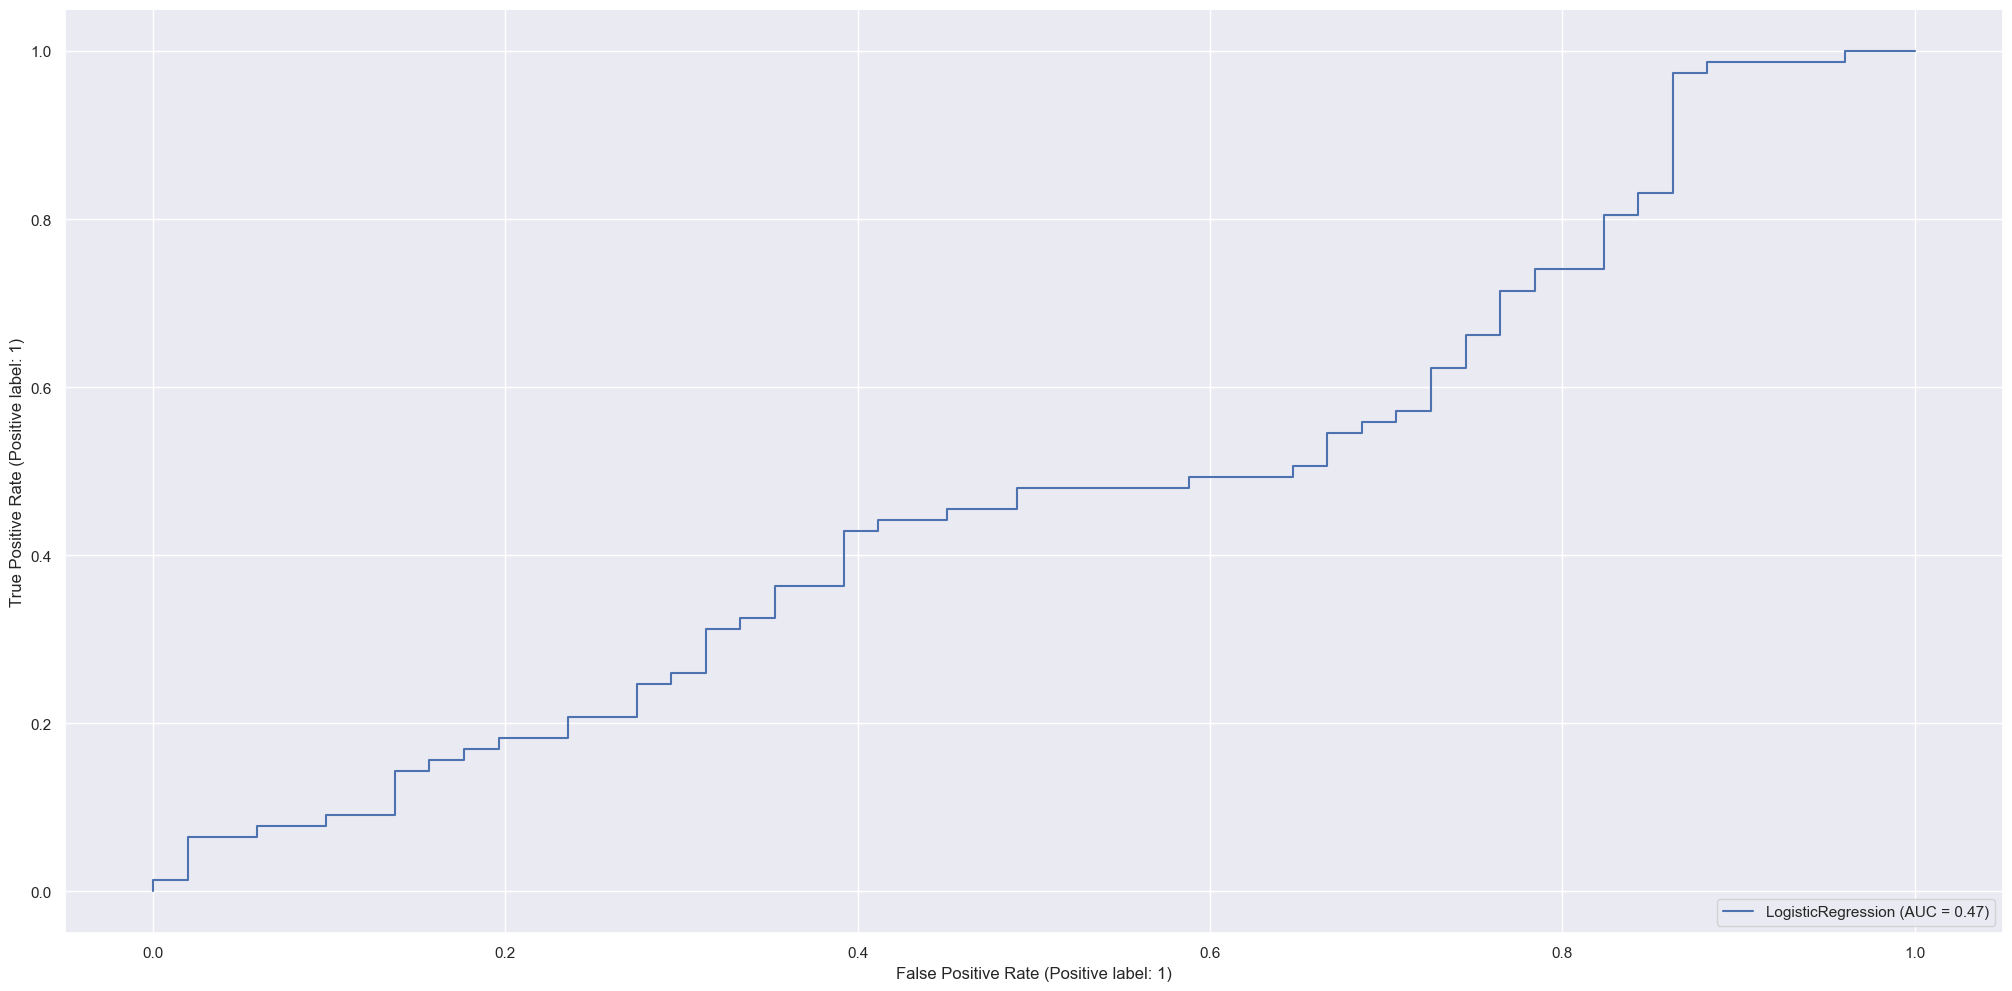

In [55]:
plot_roc_curve(lr_model, x_test1, y_test1)

# Neural Networks

## Feature Scaling

In [56]:
x_train1.head()

,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,USDEUR_Bin,USDBRL_Bin,Oil_Bin,Gold_Bin,msft_Bin,aapl_Bin,amzn_Bin,meta_Bin,brk_Bin,jnj_Bin,visa_Bin,disney_Bin,coke_Bin,mcd_Bin,nike_Bin
1158,0.333867,1,0,0,0,1.396777,0.968607,0.966501,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1
1159,0.815501,1,1,0,0,1.477689,1.033192,1.004032,0,0,1,1,0,0,1,1,1,0,1,1,0,0,1
1160,0.074214,1,1,1,0,1.120295,1.009769,0.944704,1,0,1,1,0,1,1,1,0,1,1,0,1,1,0
1161,0.323729,1,1,1,1,1.114598,1.033378,0.860544,1,0,1,0,1,1,1,1,1,0,1,1,0,1,1
1162,-0.711703,0,1,1,1,1.056801,1.066931,0.880702,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0


In [57]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sc = MinMaxScaler( feature_range = (0, 1) )
#sc = StandardScaler()
x_train1 = sc.fit_transform( x_train1 )

In [58]:
#x_train1

In [59]:
#x_test1 = np.asarray( x_test1 ).astype( np.float32 )
x_test1 = sc.transform( x_test1 )
x_test1 = np.reshape( x_test1, ( x_test1.shape[0], x_test1.shape[1], 1 ) )

## Reshaping

In [60]:
#x_train1.head()

In [61]:
x_train1 = np.asarray( x_train1 ).astype( np.float32 )
x_train1 = np.reshape( x_train1, ( x_train1.shape[0], x_train1.shape[1], 1 ) )

## Initialising the RNN

In [62]:
clf = Sequential()

## Adding the first layer and dropout regularisation

In [63]:
clf.add( LSTM( units = 100, return_sequences = True, input_shape = ( x_train1.shape[1], 1 ), dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a second layer and dropout regularisation

In [64]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a third layer and dropout regularisation

In [65]:
clf.add( LSTM( units = 100, return_sequences = True, activation='relu', dropout=0.2, recurrent_dropout=0.2 ) )
#clf.add( Dropout( 0.2 ) )

## Adding a fourth layer and dropout regularisation

In [66]:
clf.add( LSTM( units = 100, activation='relu', dropout=0.2, recurrent_dropout=0.2) )
#clf.add( Dropout( 0.2 ) )

## Adding the output layer and dropout regularisation

In [67]:
clf.add( Dense( units = 1, activation='sigmoid' ) )

## Compiling the RNN

In [68]:
clf.compile( optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics=['accuracy'] )
#clf.compile( optimizer = 'adam', loss = 'mean_squared_error')

## Fitting the RNN

In [69]:
history = clf.fit( x_train1, y_train1, epochs = 5000, batch_size = 500, shuffle=False, validation_data=(x_test1, y_test1) )

Epoch 1/5000
2/2 [==============================] - 10s 1s/step - loss: 0.6923 - accuracy: 0.5579 - val_loss: 0.6860 - val_accuracy: 0.6016
Epoch 2/5000
2/2 [==============================] - 1s 249ms/step - loss: 0.6893 - accuracy: 0.5579 - val_loss: 0.6816 - val_accuracy: 0.6016
Epoch 3/5000
2/2 [==============================] - 1s 247ms/step - loss: 0.6875 - accuracy: 0.5579 - val_loss: 0.6781 - val_accuracy: 0.6016
Epoch 4/5000
2/2 [==============================] - 1s 255ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6759 - val_accuracy: 0.6016
Epoch 5/5000
2/2 [==============================] - 1s 271ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6747 - val_accuracy: 0.6016
Epoch 6/5000
2/2 [==============================] - 1s 260ms/step - loss: 0.6874 - accuracy: 0.5579 - val_loss: 0.6742 - val_accuracy: 0.6016
Epoch 7/5000
2/2 [==============================] - 1s 268ms/step - loss: 0.6875 - accuracy: 0.5579 - val_loss: 0.6741 - val_accuracy: 0.6016
Epoch 8/

2/2 [==============================] - 2s 469ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 59/5000
2/2 [==============================] - 2s 416ms/step - loss: 0.6874 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 60/5000
2/2 [==============================] - 2s 376ms/step - loss: 0.6872 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 61/5000
2/2 [==============================] - 2s 416ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 62/5000
2/2 [==============================] - 2s 389ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 63/5000
2/2 [==============================] - 2s 407ms/step - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 64/5000
2/2 [==============================] - 2s 401ms/step - loss: 0.6871 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 65/5000

2/2 [==============================] - 2s 407ms/step - loss: 0.6872 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 116/5000
2/2 [==============================] - 2s 373ms/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 117/5000
2/2 [==============================] - 2s 391ms/step - loss: 0.6872 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 118/5000
2/2 [==============================] - 1s 372ms/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 119/5000
2/2 [==============================] - 2s 396ms/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 120/5000
2/2 [==============================] - 2s 403ms/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 121/5000
2/2 [==============================] - 1s 375ms/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 1

Epoch 172/5000
2/2 [==============================] - 2s 402ms/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 173/5000
2/2 [==============================] - 2s 407ms/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 174/5000
2/2 [==============================] - 2s 383ms/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 175/5000
2/2 [==============================] - 2s 464ms/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 176/5000
2/2 [==============================] - 2s 436ms/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 177/5000
2/2 [==============================] - 2s 425ms/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 178/5000
2/2 [==============================] - 2s 481ms/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy:

Epoch 229/5000
2/2 [==============================] - 2s 472ms/step - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 230/5000
2/2 [==============================] - 2s 446ms/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 231/5000
2/2 [==============================] - 2s 448ms/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 232/5000
2/2 [==============================] - 2s 459ms/step - loss: 0.6858 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 233/5000
2/2 [==============================] - 2s 448ms/step - loss: 0.6863 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 234/5000
2/2 [==============================] - 2s 480ms/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 235/5000
2/2 [==============================] - 2s 467ms/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy:

Epoch 286/5000
2/2 [==============================] - 2s 481ms/step - loss: 0.6864 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 287/5000
2/2 [==============================] - 2s 519ms/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 288/5000
2/2 [==============================] - 2s 506ms/step - loss: 0.6864 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 289/5000
2/2 [==============================] - 2s 507ms/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 290/5000
2/2 [==============================] - 2s 523ms/step - loss: 0.6864 - accuracy: 0.5579 - val_loss: 0.6733 - val_accuracy: 0.6016
Epoch 291/5000
2/2 [==============================] - 2s 566ms/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 292/5000
2/2 [==============================] - 2s 550ms/step - loss: 0.6864 - accuracy: 0.5579 - val_loss: 0.6732 - val_accuracy:

Epoch 343/5000
2/2 [==============================] - 2s 506ms/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 344/5000
2/2 [==============================] - 2s 517ms/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 345/5000
2/2 [==============================] - 2s 523ms/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 346/5000
2/2 [==============================] - 2s 551ms/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.6734 - val_accuracy: 0.6016
Epoch 347/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6735 - val_accuracy: 0.6016
Epoch 348/5000
2/2 [==============================] - 2s 631ms/step - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy: 0.6016
Epoch 349/5000
2/2 [==============================] - 2s 624ms/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6736 - val_accuracy:

Epoch 400/5000
2/2 [==============================] - 3s 745ms/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 401/5000
2/2 [==============================] - 3s 732ms/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 402/5000
2/2 [==============================] - 3s 586ms/step - loss: 0.6853 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 403/5000
2/2 [==============================] - 2s 548ms/step - loss: 0.6855 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 404/5000
2/2 [==============================] - 2s 550ms/step - loss: 0.6861 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 405/5000
2/2 [==============================] - 2s 568ms/step - loss: 0.6854 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 406/5000
2/2 [==============================] - 2s 560ms/step - loss: 0.6866 - accuracy: 0.5579 - val_loss: 0.6740 - val_accuracy:

Epoch 458/5000
2/2 [==============================] - 3s 730ms/step - loss: 0.6859 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 459/5000
2/2 [==============================] - 3s 731ms/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 460/5000
2/2 [==============================] - 3s 726ms/step - loss: 0.6862 - accuracy: 0.5579 - val_loss: 0.6737 - val_accuracy: 0.6016
Epoch 461/5000
2/2 [==============================] - 2s 491ms/step - loss: 0.6857 - accuracy: 0.5579 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 462/5000
2/2 [==============================] - 3s 705ms/step - loss: 0.6859 - accuracy: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6016
Epoch 463/5000
2/2 [==============================] - 2s 710ms/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6740 - val_accuracy: 0.6016
Epoch 464/5000
2/2 [==============================] - 3s 739ms/step - loss: 0.6867 - accuracy: 0.5579 - val_loss: 0.6741 - val_accuracy:

Epoch 515/5000
2/2 [==============================] - 3s 739ms/step - loss: 0.6856 - accuracy: 0.5579 - val_loss: 0.6757 - val_accuracy: 0.6016
Epoch 516/5000
2/2 [==============================] - 3s 725ms/step - loss: 0.6850 - accuracy: 0.5579 - val_loss: 0.6756 - val_accuracy: 0.6016
Epoch 517/5000
2/2 [==============================] - 3s 746ms/step - loss: 0.6863 - accuracy: 0.5579 - val_loss: 0.6759 - val_accuracy: 0.6016
Epoch 518/5000
2/2 [==============================] - 3s 743ms/step - loss: 0.6857 - accuracy: 0.5579 - val_loss: 0.6758 - val_accuracy: 0.6016
Epoch 519/5000
2/2 [==============================] - 3s 741ms/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6749 - val_accuracy: 0.6016
Epoch 520/5000
2/2 [==============================] - 3s 730ms/step - loss: 0.6850 - accuracy: 0.5579 - val_loss: 0.6757 - val_accuracy: 0.6016
Epoch 521/5000
2/2 [==============================] - 3s 711ms/step - loss: 0.6859 - accuracy: 0.5579 - val_loss: 0.6754 - val_accuracy:

Epoch 572/5000
2/2 [==============================] - 3s 612ms/step - loss: 0.6852 - accuracy: 0.5579 - val_loss: 0.6840 - val_accuracy: 0.6016
Epoch 573/5000
2/2 [==============================] - 3s 769ms/step - loss: 0.6868 - accuracy: 0.5579 - val_loss: 0.6839 - val_accuracy: 0.6016
Epoch 574/5000
2/2 [==============================] - 3s 746ms/step - loss: 0.6820 - accuracy: 0.5579 - val_loss: 0.6851 - val_accuracy: 0.6016
Epoch 575/5000
2/2 [==============================] - 3s 730ms/step - loss: 0.6863 - accuracy: 0.5579 - val_loss: 0.6827 - val_accuracy: 0.6016
Epoch 576/5000
2/2 [==============================] - 3s 791ms/step - loss: 0.6832 - accuracy: 0.5579 - val_loss: 0.6858 - val_accuracy: 0.6016
Epoch 577/5000
2/2 [==============================] - 3s 740ms/step - loss: 0.6826 - accuracy: 0.5579 - val_loss: 0.6861 - val_accuracy: 0.6016
Epoch 578/5000
2/2 [==============================] - 3s 775ms/step - loss: 0.6843 - accuracy: 0.5579 - val_loss: 0.6868 - val_accuracy:

Epoch 629/5000
2/2 [==============================] - 3s 781ms/step - loss: 0.6879 - accuracy: 0.5579 - val_loss: 0.6852 - val_accuracy: 0.6016
Epoch 630/5000
2/2 [==============================] - 3s 714ms/step - loss: 0.6870 - accuracy: 0.5579 - val_loss: 0.6855 - val_accuracy: 0.6016
Epoch 631/5000
2/2 [==============================] - 3s 743ms/step - loss: 0.6886 - accuracy: 0.5579 - val_loss: 0.6847 - val_accuracy: 0.6016
Epoch 632/5000
2/2 [==============================] - 3s 832ms/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6841 - val_accuracy: 0.6016
Epoch 633/5000
2/2 [==============================] - 3s 725ms/step - loss: 0.6876 - accuracy: 0.5579 - val_loss: 0.6846 - val_accuracy: 0.6016
Epoch 634/5000
2/2 [==============================] - 3s 765ms/step - loss: 0.6886 - accuracy: 0.5579 - val_loss: 0.6846 - val_accuracy: 0.6016
Epoch 635/5000
2/2 [==============================] - 3s 747ms/step - loss: 0.6847 - accuracy: 0.5579 - val_loss: 0.6861 - val_accuracy:

Epoch 686/5000
2/2 [==============================] - 3s 726ms/step - loss: 0.6865 - accuracy: 0.5579 - val_loss: 0.6853 - val_accuracy: 0.6016
Epoch 687/5000
2/2 [==============================] - 3s 741ms/step - loss: 0.6845 - accuracy: 0.5595 - val_loss: 0.6840 - val_accuracy: 0.6016
Epoch 688/5000
2/2 [==============================] - 3s 664ms/step - loss: 0.6846 - accuracy: 0.5595 - val_loss: 0.6845 - val_accuracy: 0.6016
Epoch 689/5000
2/2 [==============================] - 3s 734ms/step - loss: 0.6841 - accuracy: 0.5579 - val_loss: 0.6845 - val_accuracy: 0.6016
Epoch 690/5000
2/2 [==============================] - 3s 778ms/step - loss: 0.6883 - accuracy: 0.5547 - val_loss: 0.6881 - val_accuracy: 0.6016
Epoch 691/5000
2/2 [==============================] - 3s 678ms/step - loss: 0.6880 - accuracy: 0.5547 - val_loss: 0.6841 - val_accuracy: 0.6094
Epoch 692/5000
2/2 [==============================] - 3s 625ms/step - loss: 0.6843 - accuracy: 0.5563 - val_loss: 0.6771 - val_accuracy:

Epoch 744/5000
2/2 [==============================] - 6s 2s/step - loss: 0.6896 - accuracy: 0.5498 - val_loss: 0.6940 - val_accuracy: 0.6094
Epoch 745/5000
2/2 [==============================] - 6s 1s/step - loss: 0.6857 - accuracy: 0.5434 - val_loss: 0.6918 - val_accuracy: 0.6016
Epoch 746/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6853 - accuracy: 0.5466 - val_loss: 0.6917 - val_accuracy: 0.6016
Epoch 747/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6883 - accuracy: 0.5627 - val_loss: 0.6923 - val_accuracy: 0.6016
Epoch 748/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6894 - accuracy: 0.5691 - val_loss: 0.6914 - val_accuracy: 0.5938
Epoch 749/5000
2/2 [==============================] - 6s 1s/step - loss: 0.6872 - accuracy: 0.5595 - val_loss: 0.6937 - val_accuracy: 0.5938
Epoch 750/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6865 - accuracy: 0.5563 - val_loss: 0.6957 - val_accuracy: 0.6094
Epoch 751/500

2/2 [==============================] - 3s 740ms/step - loss: 0.6844 - accuracy: 0.5627 - val_loss: 0.6904 - val_accuracy: 0.6016
Epoch 802/5000
2/2 [==============================] - 3s 764ms/step - loss: 0.6844 - accuracy: 0.5595 - val_loss: 0.6879 - val_accuracy: 0.6016
Epoch 803/5000
2/2 [==============================] - 3s 742ms/step - loss: 0.6869 - accuracy: 0.5579 - val_loss: 0.6890 - val_accuracy: 0.6016
Epoch 804/5000
2/2 [==============================] - 3s 749ms/step - loss: 0.6904 - accuracy: 0.5595 - val_loss: 0.6866 - val_accuracy: 0.6016
Epoch 805/5000
2/2 [==============================] - 3s 725ms/step - loss: 0.6863 - accuracy: 0.5627 - val_loss: 0.6904 - val_accuracy: 0.6016
Epoch 806/5000
2/2 [==============================] - 3s 752ms/step - loss: 0.6838 - accuracy: 0.5563 - val_loss: 0.6922 - val_accuracy: 0.6016
Epoch 807/5000
2/2 [==============================] - 3s 767ms/step - loss: 0.6899 - accuracy: 0.5579 - val_loss: 0.6916 - val_accuracy: 0.6016
Epoch 8

Epoch 858/5000
2/2 [==============================] - 3s 774ms/step - loss: 0.6860 - accuracy: 0.5595 - val_loss: 0.6904 - val_accuracy: 0.6016
Epoch 859/5000
2/2 [==============================] - 3s 701ms/step - loss: 0.6841 - accuracy: 0.5627 - val_loss: 0.6920 - val_accuracy: 0.6094
Epoch 860/5000
2/2 [==============================] - 3s 685ms/step - loss: 0.6890 - accuracy: 0.5482 - val_loss: 0.6917 - val_accuracy: 0.6094
Epoch 861/5000
2/2 [==============================] - 3s 800ms/step - loss: 0.6851 - accuracy: 0.5579 - val_loss: 0.6927 - val_accuracy: 0.6094
Epoch 862/5000
2/2 [==============================] - 3s 826ms/step - loss: 0.6816 - accuracy: 0.5707 - val_loss: 0.6872 - val_accuracy: 0.6016
Epoch 863/5000
2/2 [==============================] - 3s 785ms/step - loss: 0.6841 - accuracy: 0.5675 - val_loss: 0.6930 - val_accuracy: 0.6016
Epoch 864/5000
2/2 [==============================] - 3s 813ms/step - loss: 0.6869 - accuracy: 0.5531 - val_loss: 0.6928 - val_accuracy:

Epoch 915/5000
2/2 [==============================] - 3s 767ms/step - loss: 0.6902 - accuracy: 0.5563 - val_loss: 0.6962 - val_accuracy: 0.5859
Epoch 916/5000
2/2 [==============================] - 3s 756ms/step - loss: 0.6840 - accuracy: 0.5611 - val_loss: 0.6990 - val_accuracy: 0.6016
Epoch 917/5000
2/2 [==============================] - 3s 738ms/step - loss: 0.6873 - accuracy: 0.5531 - val_loss: 0.7014 - val_accuracy: 0.5781
Epoch 918/5000
2/2 [==============================] - 3s 806ms/step - loss: 0.6856 - accuracy: 0.5531 - val_loss: 0.6998 - val_accuracy: 0.5703
Epoch 919/5000
2/2 [==============================] - 3s 772ms/step - loss: 0.6902 - accuracy: 0.5450 - val_loss: 0.6904 - val_accuracy: 0.5938
Epoch 920/5000
2/2 [==============================] - 3s 807ms/step - loss: 0.6834 - accuracy: 0.5579 - val_loss: 0.6991 - val_accuracy: 0.6016
Epoch 921/5000
2/2 [==============================] - 3s 779ms/step - loss: 0.6842 - accuracy: 0.5482 - val_loss: 0.6970 - val_accuracy:

Epoch 973/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6840 - accuracy: 0.5627 - val_loss: 0.6918 - val_accuracy: 0.6016
Epoch 974/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6843 - accuracy: 0.5611 - val_loss: 0.6901 - val_accuracy: 0.6094
Epoch 975/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6823 - accuracy: 0.5611 - val_loss: 0.6939 - val_accuracy: 0.6094
Epoch 976/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6837 - accuracy: 0.5659 - val_loss: 0.6968 - val_accuracy: 0.5859
Epoch 977/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6863 - accuracy: 0.5531 - val_loss: 0.6935 - val_accuracy: 0.5859
Epoch 978/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6830 - accuracy: 0.5723 - val_loss: 0.6929 - val_accuracy: 0.6016
Epoch 979/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6879 - accuracy: 0.5627 - val_loss: 0.6968 - val_accuracy: 0.5781
Epoch 980/500

Epoch 1030/5000
2/2 [==============================] - 3s 779ms/step - loss: 0.6914 - accuracy: 0.5627 - val_loss: 0.6939 - val_accuracy: 0.5938
Epoch 1031/5000
2/2 [==============================] - 3s 766ms/step - loss: 0.6902 - accuracy: 0.5434 - val_loss: 0.6954 - val_accuracy: 0.6016
Epoch 1032/5000
2/2 [==============================] - 3s 763ms/step - loss: 0.6855 - accuracy: 0.5627 - val_loss: 0.6913 - val_accuracy: 0.6016
Epoch 1033/5000
2/2 [==============================] - 3s 764ms/step - loss: 0.6841 - accuracy: 0.5563 - val_loss: 0.6971 - val_accuracy: 0.6016
Epoch 1034/5000
2/2 [==============================] - 3s 846ms/step - loss: 0.6876 - accuracy: 0.5498 - val_loss: 0.6939 - val_accuracy: 0.5781
Epoch 1035/5000
2/2 [==============================] - 3s 796ms/step - loss: 0.6871 - accuracy: 0.5595 - val_loss: 0.6934 - val_accuracy: 0.5859
Epoch 1036/5000
2/2 [==============================] - 3s 827ms/step - loss: 0.6856 - accuracy: 0.5498 - val_loss: 0.6985 - val_ac

2/2 [==============================] - 3s 800ms/step - loss: 0.6841 - accuracy: 0.5627 - val_loss: 0.6893 - val_accuracy: 0.6016
Epoch 1087/5000
2/2 [==============================] - 3s 748ms/step - loss: 0.6876 - accuracy: 0.5547 - val_loss: 0.6924 - val_accuracy: 0.5859
Epoch 1088/5000
2/2 [==============================] - 3s 782ms/step - loss: 0.6840 - accuracy: 0.5691 - val_loss: 0.6908 - val_accuracy: 0.6016
Epoch 1089/5000
2/2 [==============================] - 3s 756ms/step - loss: 0.6807 - accuracy: 0.5756 - val_loss: 0.6893 - val_accuracy: 0.5938
Epoch 1090/5000
2/2 [==============================] - 3s 752ms/step - loss: 0.6896 - accuracy: 0.5531 - val_loss: 0.6927 - val_accuracy: 0.5938
Epoch 1091/5000
2/2 [==============================] - 3s 757ms/step - loss: 0.6847 - accuracy: 0.5563 - val_loss: 0.6929 - val_accuracy: 0.6016
Epoch 1092/5000
2/2 [==============================] - 3s 772ms/step - loss: 0.6874 - accuracy: 0.5563 - val_loss: 0.6831 - val_accuracy: 0.5938
E

Epoch 1143/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6901 - accuracy: 0.5547 - val_loss: 0.6955 - val_accuracy: 0.6016
Epoch 1144/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6849 - accuracy: 0.5707 - val_loss: 0.6967 - val_accuracy: 0.6016
Epoch 1145/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6920 - accuracy: 0.5547 - val_loss: 0.6882 - val_accuracy: 0.5859
Epoch 1146/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6910 - accuracy: 0.5531 - val_loss: 0.6915 - val_accuracy: 0.6016
Epoch 1147/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6874 - accuracy: 0.5547 - val_loss: 0.6959 - val_accuracy: 0.5938
Epoch 1148/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6818 - accuracy: 0.5579 - val_loss: 0.6966 - val_accuracy: 0.5938
Epoch 1149/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6938 - accuracy: 0.5434 - val_loss: 0.6932 - val_accuracy: 0.6016
Epoch 

Epoch 1201/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6843 - accuracy: 0.5627 - val_loss: 0.6934 - val_accuracy: 0.5859
Epoch 1202/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6881 - accuracy: 0.5595 - val_loss: 0.6942 - val_accuracy: 0.5859
Epoch 1203/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6861 - accuracy: 0.5482 - val_loss: 0.6954 - val_accuracy: 0.5938
Epoch 1204/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6876 - accuracy: 0.5595 - val_loss: 0.6933 - val_accuracy: 0.5938
Epoch 1205/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6897 - accuracy: 0.5627 - val_loss: 0.6934 - val_accuracy: 0.5938
Epoch 1206/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6866 - accuracy: 0.5547 - val_loss: 0.6926 - val_accuracy: 0.5938
Epoch 1207/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6877 - accuracy: 0.5579 - val_loss: 0.6906 - val_accuracy: 0.5938
Epoch 

Epoch 1259/5000
2/2 [==============================] - 6s 2s/step - loss: 0.6882 - accuracy: 0.5563 - val_loss: 0.6940 - val_accuracy: 0.5938
Epoch 1260/5000
2/2 [==============================] - 7s 2s/step - loss: 0.6896 - accuracy: 0.5563 - val_loss: 0.6909 - val_accuracy: 0.5938
Epoch 1261/5000
2/2 [==============================] - 6s 1s/step - loss: 0.6886 - accuracy: 0.5595 - val_loss: 0.6935 - val_accuracy: 0.6016
Epoch 1262/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6865 - accuracy: 0.5547 - val_loss: 0.6934 - val_accuracy: 0.6016
Epoch 1263/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6846 - accuracy: 0.5627 - val_loss: 0.6939 - val_accuracy: 0.6016
Epoch 1264/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6875 - accuracy: 0.5547 - val_loss: 0.6935 - val_accuracy: 0.5859
Epoch 1265/5000
2/2 [==============================] - 6s 1s/step - loss: 0.6816 - accuracy: 0.5579 - val_loss: 0.6898 - val_accuracy: 0.5859
Epoch 

2/2 [==============================] - 3s 741ms/step - loss: 0.6828 - accuracy: 0.5482 - val_loss: 0.7006 - val_accuracy: 0.6016
Epoch 1317/5000
2/2 [==============================] - 3s 749ms/step - loss: 0.6792 - accuracy: 0.5659 - val_loss: 0.6999 - val_accuracy: 0.5938
Epoch 1318/5000
2/2 [==============================] - 3s 742ms/step - loss: 0.6849 - accuracy: 0.5563 - val_loss: 0.7070 - val_accuracy: 0.5938
Epoch 1319/5000
2/2 [==============================] - 3s 761ms/step - loss: 0.6866 - accuracy: 0.5627 - val_loss: 0.7031 - val_accuracy: 0.5938
Epoch 1320/5000
2/2 [==============================] - 3s 772ms/step - loss: 0.6888 - accuracy: 0.5434 - val_loss: 0.7065 - val_accuracy: 0.5859
Epoch 1321/5000
2/2 [==============================] - 2s 602ms/step - loss: 0.6857 - accuracy: 0.5579 - val_loss: 0.7008 - val_accuracy: 0.6016
Epoch 1322/5000
2/2 [==============================] - 3s 727ms/step - loss: 0.6883 - accuracy: 0.5547 - val_loss: 0.7005 - val_accuracy: 0.6016
E

2/2 [==============================] - 3s 748ms/step - loss: 0.6847 - accuracy: 0.5595 - val_loss: 0.6945 - val_accuracy: 0.5781
Epoch 1373/5000
2/2 [==============================] - 3s 729ms/step - loss: 0.6842 - accuracy: 0.5595 - val_loss: 0.6897 - val_accuracy: 0.6016
Epoch 1374/5000
2/2 [==============================] - 3s 679ms/step - loss: 0.6860 - accuracy: 0.5723 - val_loss: 0.6928 - val_accuracy: 0.6016
Epoch 1375/5000
2/2 [==============================] - 3s 613ms/step - loss: 0.6868 - accuracy: 0.5675 - val_loss: 0.6984 - val_accuracy: 0.5859
Epoch 1376/5000
2/2 [==============================] - 3s 730ms/step - loss: 0.6892 - accuracy: 0.5498 - val_loss: 0.6916 - val_accuracy: 0.5781
Epoch 1377/5000
2/2 [==============================] - 3s 752ms/step - loss: 0.6838 - accuracy: 0.5498 - val_loss: 0.6950 - val_accuracy: 0.5781
Epoch 1378/5000
2/2 [==============================] - 2s 629ms/step - loss: 0.6822 - accuracy: 0.5675 - val_loss: 0.6958 - val_accuracy: 0.5859
E

2/2 [==============================] - 2s 582ms/step - loss: 0.6893 - accuracy: 0.5354 - val_loss: 0.7006 - val_accuracy: 0.5781
Epoch 1429/5000
2/2 [==============================] - 3s 655ms/step - loss: 0.6832 - accuracy: 0.5723 - val_loss: 0.6990 - val_accuracy: 0.5938
Epoch 1430/5000
2/2 [==============================] - 2s 603ms/step - loss: 0.6889 - accuracy: 0.5595 - val_loss: 0.6979 - val_accuracy: 0.6016
Epoch 1431/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6919 - accuracy: 0.5595 - val_loss: 0.6978 - val_accuracy: 0.5781
Epoch 1432/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6905 - accuracy: 0.5305 - val_loss: 0.6952 - val_accuracy: 0.5938
Epoch 1433/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6840 - accuracy: 0.5691 - val_loss: 0.6965 - val_accuracy: 0.5859
Epoch 1434/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6830 - accuracy: 0.5691 - val_loss: 0.6979 - val_accuracy: 0.5781
Epoch 1435/50

Epoch 1486/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6830 - accuracy: 0.5772 - val_loss: 0.6977 - val_accuracy: 0.6016
Epoch 1487/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6897 - accuracy: 0.5563 - val_loss: 0.6963 - val_accuracy: 0.5859
Epoch 1488/5000
2/2 [==============================] - 4s 987ms/step - loss: 0.6889 - accuracy: 0.5691 - val_loss: 0.6974 - val_accuracy: 0.6016
Epoch 1489/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6883 - accuracy: 0.5482 - val_loss: 0.6941 - val_accuracy: 0.5859
Epoch 1490/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6878 - accuracy: 0.5627 - val_loss: 0.6942 - val_accuracy: 0.6016
Epoch 1491/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6819 - accuracy: 0.5788 - val_loss: 0.6924 - val_accuracy: 0.6016
Epoch 1492/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6875 - accuracy: 0.5531 - val_loss: 0.6919 - val_accuracy: 0.6016
Epo

Epoch 1543/5000
2/2 [==============================] - 2s 657ms/step - loss: 0.6854 - accuracy: 0.5643 - val_loss: 0.6961 - val_accuracy: 0.5938
Epoch 1544/5000
2/2 [==============================] - 3s 702ms/step - loss: 0.6858 - accuracy: 0.5482 - val_loss: 0.6981 - val_accuracy: 0.5859
Epoch 1545/5000
2/2 [==============================] - 2s 632ms/step - loss: 0.6870 - accuracy: 0.5466 - val_loss: 0.6986 - val_accuracy: 0.5859
Epoch 1546/5000
2/2 [==============================] - 3s 772ms/step - loss: 0.6807 - accuracy: 0.5627 - val_loss: 0.6999 - val_accuracy: 0.5859
Epoch 1547/5000
2/2 [==============================] - 2s 751ms/step - loss: 0.6831 - accuracy: 0.5466 - val_loss: 0.7004 - val_accuracy: 0.5859
Epoch 1548/5000
2/2 [==============================] - 3s 632ms/step - loss: 0.6931 - accuracy: 0.5418 - val_loss: 0.6951 - val_accuracy: 0.5859
Epoch 1549/5000
2/2 [==============================] - 3s 774ms/step - loss: 0.6874 - accuracy: 0.5498 - val_loss: 0.6997 - val_ac

2/2 [==============================] - 2s 615ms/step - loss: 0.6865 - accuracy: 0.5466 - val_loss: 0.6993 - val_accuracy: 0.5938
Epoch 1600/5000
2/2 [==============================] - 2s 579ms/step - loss: 0.6826 - accuracy: 0.5595 - val_loss: 0.7003 - val_accuracy: 0.5703
Epoch 1601/5000
2/2 [==============================] - 2s 635ms/step - loss: 0.6856 - accuracy: 0.5643 - val_loss: 0.6983 - val_accuracy: 0.6016
Epoch 1602/5000
2/2 [==============================] - 3s 744ms/step - loss: 0.6929 - accuracy: 0.5466 - val_loss: 0.6969 - val_accuracy: 0.5938
Epoch 1603/5000
2/2 [==============================] - 2s 596ms/step - loss: 0.6859 - accuracy: 0.5563 - val_loss: 0.6988 - val_accuracy: 0.5781
Epoch 1604/5000
2/2 [==============================] - 3s 754ms/step - loss: 0.6851 - accuracy: 0.5643 - val_loss: 0.6958 - val_accuracy: 0.5781
Epoch 1605/5000
2/2 [==============================] - 3s 733ms/step - loss: 0.6853 - accuracy: 0.5563 - val_loss: 0.6937 - val_accuracy: 0.6016
E

Epoch 1656/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6880 - accuracy: 0.5595 - val_loss: 0.6966 - val_accuracy: 0.5938
Epoch 1657/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6853 - accuracy: 0.5627 - val_loss: 0.6987 - val_accuracy: 0.5938
Epoch 1658/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6886 - accuracy: 0.5514 - val_loss: 0.6984 - val_accuracy: 0.5781
Epoch 1659/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6810 - accuracy: 0.5531 - val_loss: 0.6991 - val_accuracy: 0.5938
Epoch 1660/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6816 - accuracy: 0.5579 - val_loss: 0.6997 - val_accuracy: 0.5938
Epoch 1661/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6872 - accuracy: 0.5482 - val_loss: 0.6999 - val_accuracy: 0.6016
Epoch 1662/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6880 - accuracy: 0.5579 - val_loss: 0.7010 - val_accuracy: 0.5938
Epoch 

Epoch 1714/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6865 - accuracy: 0.5531 - val_loss: 0.6986 - val_accuracy: 0.5938
Epoch 1715/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6856 - accuracy: 0.5595 - val_loss: 0.6984 - val_accuracy: 0.5938
Epoch 1716/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6787 - accuracy: 0.5675 - val_loss: 0.7023 - val_accuracy: 0.5938
Epoch 1717/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6788 - accuracy: 0.5643 - val_loss: 0.7008 - val_accuracy: 0.6016
Epoch 1718/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6851 - accuracy: 0.5691 - val_loss: 0.7064 - val_accuracy: 0.5859
Epoch 1719/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6874 - accuracy: 0.5563 - val_loss: 0.7019 - val_accuracy: 0.5938
Epoch 1720/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6826 - accuracy: 0.5675 - val_loss: 0.7024 - val_accuracy: 0.5938
Epoch 

Epoch 1771/5000
2/2 [==============================] - 3s 687ms/step - loss: 0.6837 - accuracy: 0.5707 - val_loss: 0.7042 - val_accuracy: 0.6016
Epoch 1772/5000
2/2 [==============================] - 3s 768ms/step - loss: 0.6869 - accuracy: 0.5595 - val_loss: 0.7062 - val_accuracy: 0.6094
Epoch 1773/5000
2/2 [==============================] - 3s 706ms/step - loss: 0.6832 - accuracy: 0.5595 - val_loss: 0.7084 - val_accuracy: 0.5625
Epoch 1774/5000
2/2 [==============================] - 3s 763ms/step - loss: 0.6944 - accuracy: 0.5402 - val_loss: 0.7025 - val_accuracy: 0.6016
Epoch 1775/5000
2/2 [==============================] - 3s 777ms/step - loss: 0.6878 - accuracy: 0.5531 - val_loss: 0.7027 - val_accuracy: 0.5859
Epoch 1776/5000
2/2 [==============================] - 3s 753ms/step - loss: 0.6922 - accuracy: 0.5434 - val_loss: 0.7029 - val_accuracy: 0.5859
Epoch 1777/5000
2/2 [==============================] - 3s 772ms/step - loss: 0.6829 - accuracy: 0.5531 - val_loss: 0.7065 - val_ac

2/2 [==============================] - 3s 657ms/step - loss: 0.6904 - accuracy: 0.5723 - val_loss: 0.6996 - val_accuracy: 0.5938
Epoch 1828/5000
2/2 [==============================] - 3s 641ms/step - loss: 0.6858 - accuracy: 0.5547 - val_loss: 0.7024 - val_accuracy: 0.5938
Epoch 1829/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6860 - accuracy: 0.5563 - val_loss: 0.7027 - val_accuracy: 0.5859
Epoch 1830/5000
2/2 [==============================] - 3s 712ms/step - loss: 0.6881 - accuracy: 0.5547 - val_loss: 0.7027 - val_accuracy: 0.5938
Epoch 1831/5000
2/2 [==============================] - 2s 644ms/step - loss: 0.6861 - accuracy: 0.5627 - val_loss: 0.7029 - val_accuracy: 0.5781
Epoch 1832/5000
2/2 [==============================] - 2s 695ms/step - loss: 0.6920 - accuracy: 0.5514 - val_loss: 0.7006 - val_accuracy: 0.6016
Epoch 1833/5000
2/2 [==============================] - 3s 718ms/step - loss: 0.6791 - accuracy: 0.5723 - val_loss: 0.6987 - val_accuracy: 0.6016
E

Epoch 1884/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6882 - accuracy: 0.5691 - val_loss: 0.7022 - val_accuracy: 0.5938
Epoch 1885/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6931 - accuracy: 0.5514 - val_loss: 0.6976 - val_accuracy: 0.6016
Epoch 1886/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6792 - accuracy: 0.5579 - val_loss: 0.7001 - val_accuracy: 0.5938
Epoch 1887/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6879 - accuracy: 0.5482 - val_loss: 0.6991 - val_accuracy: 0.6016
Epoch 1888/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6839 - accuracy: 0.5675 - val_loss: 0.7011 - val_accuracy: 0.5938
Epoch 1889/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6820 - accuracy: 0.5756 - val_loss: 0.7015 - val_accuracy: 0.6094
Epoch 1890/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6857 - accuracy: 0.5498 - val_loss: 0.7006 - val_accuracy: 0.5859
Epoch 

2/2 [==============================] - 4s 1s/step - loss: 0.6814 - accuracy: 0.5498 - val_loss: 0.6996 - val_accuracy: 0.5859
Epoch 1942/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6817 - accuracy: 0.5659 - val_loss: 0.6998 - val_accuracy: 0.5703
Epoch 1943/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6820 - accuracy: 0.5643 - val_loss: 0.7076 - val_accuracy: 0.5938
Epoch 1944/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6931 - accuracy: 0.5611 - val_loss: 0.6988 - val_accuracy: 0.5938
Epoch 1945/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6857 - accuracy: 0.5659 - val_loss: 0.7042 - val_accuracy: 0.5938
Epoch 1946/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6933 - accuracy: 0.5482 - val_loss: 0.6941 - val_accuracy: 0.6016
Epoch 1947/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6841 - accuracy: 0.5723 - val_loss: 0.7044 - val_accuracy: 0.5859
Epoch 1948/5000
2/2 [=

Epoch 1998/5000
2/2 [==============================] - 2s 670ms/step - loss: 0.6827 - accuracy: 0.5756 - val_loss: 0.7061 - val_accuracy: 0.6016
Epoch 1999/5000
2/2 [==============================] - 2s 621ms/step - loss: 0.6864 - accuracy: 0.5772 - val_loss: 0.7045 - val_accuracy: 0.6016
Epoch 2000/5000
2/2 [==============================] - 2s 613ms/step - loss: 0.6844 - accuracy: 0.5756 - val_loss: 0.7081 - val_accuracy: 0.5938
Epoch 2001/5000
2/2 [==============================] - 2s 638ms/step - loss: 0.6909 - accuracy: 0.5563 - val_loss: 0.7027 - val_accuracy: 0.6016
Epoch 2002/5000
2/2 [==============================] - 3s 722ms/step - loss: 0.6964 - accuracy: 0.5466 - val_loss: 0.7000 - val_accuracy: 0.5938
Epoch 2003/5000
2/2 [==============================] - 3s 796ms/step - loss: 0.6818 - accuracy: 0.5820 - val_loss: 0.7016 - val_accuracy: 0.6016
Epoch 2004/5000
2/2 [==============================] - 3s 605ms/step - loss: 0.6829 - accuracy: 0.5659 - val_loss: 0.7026 - val_ac

2/2 [==============================] - 2s 610ms/step - loss: 0.6849 - accuracy: 0.5627 - val_loss: 0.7041 - val_accuracy: 0.5781
Epoch 2055/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6872 - accuracy: 0.5659 - val_loss: 0.7063 - val_accuracy: 0.5781
Epoch 2056/5000
2/2 [==============================] - 2s 618ms/step - loss: 0.6871 - accuracy: 0.5531 - val_loss: 0.7068 - val_accuracy: 0.5781
Epoch 2057/5000
2/2 [==============================] - 2s 641ms/step - loss: 0.6805 - accuracy: 0.5627 - val_loss: 0.7029 - val_accuracy: 0.5781
Epoch 2058/5000
2/2 [==============================] - 3s 641ms/step - loss: 0.6885 - accuracy: 0.5659 - val_loss: 0.7023 - val_accuracy: 0.5859
Epoch 2059/5000
2/2 [==============================] - 2s 648ms/step - loss: 0.6817 - accuracy: 0.5659 - val_loss: 0.6993 - val_accuracy: 0.5859
Epoch 2060/5000
2/2 [==============================] - 2s 673ms/step - loss: 0.6849 - accuracy: 0.5740 - val_loss: 0.7025 - val_accuracy: 0.5859
E

Epoch 2111/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6907 - accuracy: 0.5531 - val_loss: 0.7006 - val_accuracy: 0.5938
Epoch 2112/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6881 - accuracy: 0.5675 - val_loss: 0.7010 - val_accuracy: 0.6016
Epoch 2113/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6821 - accuracy: 0.5611 - val_loss: 0.6999 - val_accuracy: 0.5938
Epoch 2114/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6838 - accuracy: 0.5691 - val_loss: 0.7080 - val_accuracy: 0.6016
Epoch 2115/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6817 - accuracy: 0.5547 - val_loss: 0.7064 - val_accuracy: 0.6094
Epoch 2116/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6821 - accuracy: 0.5466 - val_loss: 0.7107 - val_accuracy: 0.5703
Epoch 2117/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6909 - accuracy: 0.5418 - val_loss: 0.7021 - val_accuracy: 0.6094
Epoch 

Epoch 2169/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6845 - accuracy: 0.5514 - val_loss: 0.7040 - val_accuracy: 0.5938
Epoch 2170/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6898 - accuracy: 0.5466 - val_loss: 0.6953 - val_accuracy: 0.5938
Epoch 2171/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6855 - accuracy: 0.5595 - val_loss: 0.7029 - val_accuracy: 0.5938
Epoch 2172/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6829 - accuracy: 0.5627 - val_loss: 0.7056 - val_accuracy: 0.6016
Epoch 2173/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6829 - accuracy: 0.5740 - val_loss: 0.7014 - val_accuracy: 0.5938
Epoch 2174/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6869 - accuracy: 0.5547 - val_loss: 0.7030 - val_accuracy: 0.6016
Epoch 2175/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6945 - accuracy: 0.5322 - val_loss: 0.7004 - val_accuracy: 0.6016
Epoch 

2/2 [==============================] - 4s 1s/step - loss: 0.6825 - accuracy: 0.5514 - val_loss: 0.7042 - val_accuracy: 0.6172
Epoch 2227/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6934 - accuracy: 0.5466 - val_loss: 0.7102 - val_accuracy: 0.6016
Epoch 2228/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6889 - accuracy: 0.5707 - val_loss: 0.7076 - val_accuracy: 0.6094
Epoch 2229/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6808 - accuracy: 0.5563 - val_loss: 0.7059 - val_accuracy: 0.6016
Epoch 2230/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6967 - accuracy: 0.5482 - val_loss: 0.7019 - val_accuracy: 0.6094
Epoch 2231/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6811 - accuracy: 0.5611 - val_loss: 0.7021 - val_accuracy: 0.6016
Epoch 2232/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6872 - accuracy: 0.5563 - val_loss: 0.7052 - val_accuracy: 0.6016
Epoch 2233/5000
2/2 [=

2/2 [==============================] - 2s 627ms/step - loss: 0.6898 - accuracy: 0.5643 - val_loss: 0.6960 - val_accuracy: 0.5938
Epoch 2284/5000
2/2 [==============================] - 2s 632ms/step - loss: 0.6844 - accuracy: 0.5450 - val_loss: 0.7060 - val_accuracy: 0.6016
Epoch 2285/5000
2/2 [==============================] - 2s 613ms/step - loss: 0.6924 - accuracy: 0.5611 - val_loss: 0.7061 - val_accuracy: 0.6016
Epoch 2286/5000
2/2 [==============================] - 2s 753ms/step - loss: 0.6847 - accuracy: 0.5643 - val_loss: 0.7073 - val_accuracy: 0.5938
Epoch 2287/5000
2/2 [==============================] - 3s 624ms/step - loss: 0.6830 - accuracy: 0.5595 - val_loss: 0.7027 - val_accuracy: 0.5938
Epoch 2288/5000
2/2 [==============================] - 2s 655ms/step - loss: 0.6805 - accuracy: 0.5595 - val_loss: 0.7038 - val_accuracy: 0.5938
Epoch 2289/5000
2/2 [==============================] - 2s 641ms/step - loss: 0.6876 - accuracy: 0.5707 - val_loss: 0.7000 - val_accuracy: 0.6016
E

2/2 [==============================] - 3s 656ms/step - loss: 0.6754 - accuracy: 0.5627 - val_loss: 0.7047 - val_accuracy: 0.6016
Epoch 2340/5000
2/2 [==============================] - 3s 712ms/step - loss: 0.6881 - accuracy: 0.5659 - val_loss: 0.6932 - val_accuracy: 0.6016
Epoch 2341/5000
2/2 [==============================] - 3s 787ms/step - loss: 0.6800 - accuracy: 0.5643 - val_loss: 0.7011 - val_accuracy: 0.6094
Epoch 2342/5000
2/2 [==============================] - 3s 664ms/step - loss: 0.6874 - accuracy: 0.5450 - val_loss: 0.7039 - val_accuracy: 0.6016
Epoch 2343/5000
2/2 [==============================] - 3s 645ms/step - loss: 0.6863 - accuracy: 0.5691 - val_loss: 0.6975 - val_accuracy: 0.6094
Epoch 2344/5000
2/2 [==============================] - 3s 636ms/step - loss: 0.6882 - accuracy: 0.5547 - val_loss: 0.7014 - val_accuracy: 0.5859
Epoch 2345/5000
2/2 [==============================] - 3s 602ms/step - loss: 0.6800 - accuracy: 0.5595 - val_loss: 0.7074 - val_accuracy: 0.6016
E

2/2 [==============================] - 3s 708ms/step - loss: 0.6761 - accuracy: 0.5659 - val_loss: 0.7123 - val_accuracy: 0.6016
Epoch 2396/5000
2/2 [==============================] - 3s 624ms/step - loss: 0.6880 - accuracy: 0.5611 - val_loss: 0.7018 - val_accuracy: 0.5938
Epoch 2397/5000
2/2 [==============================] - 3s 753ms/step - loss: 0.6797 - accuracy: 0.5659 - val_loss: 0.7122 - val_accuracy: 0.6094
Epoch 2398/5000
2/2 [==============================] - 3s 700ms/step - loss: 0.6920 - accuracy: 0.5563 - val_loss: 0.7076 - val_accuracy: 0.5938
Epoch 2399/5000
2/2 [==============================] - 3s 651ms/step - loss: 0.6906 - accuracy: 0.5627 - val_loss: 0.7085 - val_accuracy: 0.5703
Epoch 2400/5000
2/2 [==============================] - 2s 640ms/step - loss: 0.6794 - accuracy: 0.5788 - val_loss: 0.7051 - val_accuracy: 0.6016
Epoch 2401/5000
2/2 [==============================] - 2s 590ms/step - loss: 0.6847 - accuracy: 0.5563 - val_loss: 0.7064 - val_accuracy: 0.5859
E

Epoch 2452/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6888 - accuracy: 0.5547 - val_loss: 0.7077 - val_accuracy: 0.5781
Epoch 2453/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6901 - accuracy: 0.5514 - val_loss: 0.7030 - val_accuracy: 0.5938
Epoch 2454/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6872 - accuracy: 0.5627 - val_loss: 0.6965 - val_accuracy: 0.6016
Epoch 2455/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6756 - accuracy: 0.5627 - val_loss: 0.7018 - val_accuracy: 0.6172
Epoch 2456/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6864 - accuracy: 0.5691 - val_loss: 0.7008 - val_accuracy: 0.5938
Epoch 2457/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6858 - accuracy: 0.5531 - val_loss: 0.7063 - val_accuracy: 0.5781
Epoch 2458/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6911 - accuracy: 0.5707 - val_loss: 0.7005 - val_accuracy: 0.6016
Epoch 

2/2 [==============================] - 3s 757ms/step - loss: 0.6813 - accuracy: 0.5756 - val_loss: 0.6992 - val_accuracy: 0.6016
Epoch 2510/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6762 - accuracy: 0.5643 - val_loss: 0.7125 - val_accuracy: 0.6094
Epoch 2511/5000
2/2 [==============================] - 2s 658ms/step - loss: 0.6870 - accuracy: 0.5659 - val_loss: 0.6981 - val_accuracy: 0.6172
Epoch 2512/5000
2/2 [==============================] - 2s 632ms/step - loss: 0.6875 - accuracy: 0.5643 - val_loss: 0.6964 - val_accuracy: 0.6094
Epoch 2513/5000
2/2 [==============================] - 3s 720ms/step - loss: 0.6825 - accuracy: 0.5627 - val_loss: 0.7081 - val_accuracy: 0.6094
Epoch 2514/5000
2/2 [==============================] - 2s 656ms/step - loss: 0.6775 - accuracy: 0.5723 - val_loss: 0.7136 - val_accuracy: 0.6172
Epoch 2515/5000
2/2 [==============================] - 2s 719ms/step - loss: 0.6844 - accuracy: 0.5788 - val_loss: 0.7135 - val_accuracy: 0.6172
E

2/2 [==============================] - 2s 624ms/step - loss: 0.6868 - accuracy: 0.5514 - val_loss: 0.7105 - val_accuracy: 0.6172
Epoch 2566/5000
2/2 [==============================] - 2s 612ms/step - loss: 0.6863 - accuracy: 0.5723 - val_loss: 0.7108 - val_accuracy: 0.6172
Epoch 2567/5000
2/2 [==============================] - 2s 654ms/step - loss: 0.6927 - accuracy: 0.5466 - val_loss: 0.7018 - val_accuracy: 0.6172
Epoch 2568/5000
2/2 [==============================] - 2s 635ms/step - loss: 0.6744 - accuracy: 0.5900 - val_loss: 0.7198 - val_accuracy: 0.5938
Epoch 2569/5000
2/2 [==============================] - 2s 575ms/step - loss: 0.6879 - accuracy: 0.5772 - val_loss: 0.7068 - val_accuracy: 0.6094
Epoch 2570/5000
2/2 [==============================] - 2s 651ms/step - loss: 0.6770 - accuracy: 0.5723 - val_loss: 0.7161 - val_accuracy: 0.6172
Epoch 2571/5000
2/2 [==============================] - 2s 670ms/step - loss: 0.6908 - accuracy: 0.5514 - val_loss: 0.7120 - val_accuracy: 0.6094
E

2/2 [==============================] - 2s 610ms/step - loss: 0.6756 - accuracy: 0.6013 - val_loss: 0.7125 - val_accuracy: 0.5859
Epoch 2622/5000
2/2 [==============================] - 2s 602ms/step - loss: 0.6866 - accuracy: 0.5723 - val_loss: 0.7260 - val_accuracy: 0.5938
Epoch 2623/5000
2/2 [==============================] - 3s 756ms/step - loss: 0.6967 - accuracy: 0.5563 - val_loss: 0.7051 - val_accuracy: 0.5859
Epoch 2624/5000
2/2 [==============================] - 2s 639ms/step - loss: 0.6936 - accuracy: 0.5723 - val_loss: 0.7107 - val_accuracy: 0.5781
Epoch 2625/5000
2/2 [==============================] - 2s 634ms/step - loss: 0.6674 - accuracy: 0.5804 - val_loss: 0.7250 - val_accuracy: 0.6016
Epoch 2626/5000
2/2 [==============================] - 2s 700ms/step - loss: 0.6792 - accuracy: 0.5804 - val_loss: 0.7213 - val_accuracy: 0.5938
Epoch 2627/5000
2/2 [==============================] - 3s 755ms/step - loss: 0.6793 - accuracy: 0.5836 - val_loss: 0.7168 - val_accuracy: 0.6094
E

2/2 [==============================] - 2s 632ms/step - loss: 0.6841 - accuracy: 0.5675 - val_loss: 0.7164 - val_accuracy: 0.5938
Epoch 2678/5000
2/2 [==============================] - 3s 652ms/step - loss: 0.6803 - accuracy: 0.5611 - val_loss: 0.7317 - val_accuracy: 0.5781
Epoch 2679/5000
2/2 [==============================] - 3s 787ms/step - loss: 0.6909 - accuracy: 0.5723 - val_loss: 0.7184 - val_accuracy: 0.6016
Epoch 2680/5000
2/2 [==============================] - 3s 649ms/step - loss: 0.6863 - accuracy: 0.5418 - val_loss: 0.7149 - val_accuracy: 0.5703
Epoch 2681/5000
2/2 [==============================] - 2s 604ms/step - loss: 0.6807 - accuracy: 0.5563 - val_loss: 0.7085 - val_accuracy: 0.5859
Epoch 2682/5000
2/2 [==============================] - 2s 603ms/step - loss: 0.6872 - accuracy: 0.5547 - val_loss: 0.7137 - val_accuracy: 0.5859
Epoch 2683/5000
2/2 [==============================] - 2s 713ms/step - loss: 0.6780 - accuracy: 0.5723 - val_loss: 0.7058 - val_accuracy: 0.6094
E

2/2 [==============================] - 2s 760ms/step - loss: 0.6859 - accuracy: 0.5707 - val_loss: 0.7158 - val_accuracy: 0.6328
Epoch 2734/5000
2/2 [==============================] - 2s 663ms/step - loss: 0.6784 - accuracy: 0.5788 - val_loss: 0.7224 - val_accuracy: 0.6172
Epoch 2735/5000
2/2 [==============================] - 2s 613ms/step - loss: 0.6818 - accuracy: 0.5723 - val_loss: 0.7332 - val_accuracy: 0.6016
Epoch 2736/5000
2/2 [==============================] - 2s 612ms/step - loss: 0.6966 - accuracy: 0.5659 - val_loss: 0.7161 - val_accuracy: 0.6250
Epoch 2737/5000
2/2 [==============================] - 3s 729ms/step - loss: 0.6767 - accuracy: 0.5884 - val_loss: 0.7083 - val_accuracy: 0.6016
Epoch 2738/5000
2/2 [==============================] - 3s 752ms/step - loss: 0.6814 - accuracy: 0.5707 - val_loss: 0.7201 - val_accuracy: 0.5938
Epoch 2739/5000
2/2 [==============================] - 2s 598ms/step - loss: 0.6726 - accuracy: 0.5691 - val_loss: 0.7216 - val_accuracy: 0.6016
E

2/2 [==============================] - 3s 752ms/step - loss: 0.6867 - accuracy: 0.5691 - val_loss: 0.7239 - val_accuracy: 0.5625
Epoch 2790/5000
2/2 [==============================] - 2s 648ms/step - loss: 0.6811 - accuracy: 0.5740 - val_loss: 0.7255 - val_accuracy: 0.6094
Epoch 2791/5000
2/2 [==============================] - 3s 778ms/step - loss: 0.6816 - accuracy: 0.5611 - val_loss: 0.7106 - val_accuracy: 0.5781
Epoch 2792/5000
2/2 [==============================] - 3s 764ms/step - loss: 0.6865 - accuracy: 0.5611 - val_loss: 0.7060 - val_accuracy: 0.5703
Epoch 2793/5000
2/2 [==============================] - 2s 621ms/step - loss: 0.6759 - accuracy: 0.5772 - val_loss: 0.7256 - val_accuracy: 0.5781
Epoch 2794/5000
2/2 [==============================] - 3s 764ms/step - loss: 0.6783 - accuracy: 0.5675 - val_loss: 0.7272 - val_accuracy: 0.5859
Epoch 2795/5000
2/2 [==============================] - 3s 746ms/step - loss: 0.6874 - accuracy: 0.5659 - val_loss: 0.7296 - val_accuracy: 0.5469
E

2/2 [==============================] - 4s 1s/step - loss: 0.6871 - accuracy: 0.5723 - val_loss: 0.7310 - val_accuracy: 0.5703
Epoch 2847/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6744 - accuracy: 0.5772 - val_loss: 0.7239 - val_accuracy: 0.5938
Epoch 2848/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6828 - accuracy: 0.5788 - val_loss: 0.7137 - val_accuracy: 0.5781
Epoch 2849/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6776 - accuracy: 0.5772 - val_loss: 0.7380 - val_accuracy: 0.5859
Epoch 2850/5000
2/2 [==============================] - 4s 983ms/step - loss: 0.6579 - accuracy: 0.6061 - val_loss: 0.7417 - val_accuracy: 0.5703
Epoch 2851/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6856 - accuracy: 0.5723 - val_loss: 0.7225 - val_accuracy: 0.5859
Epoch 2852/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6928 - accuracy: 0.5900 - val_loss: 0.7282 - val_accuracy: 0.5859
Epoch 2853/5000
2/2

Epoch 2904/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6669 - accuracy: 0.5900 - val_loss: 0.7267 - val_accuracy: 0.5625
Epoch 2905/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6735 - accuracy: 0.5836 - val_loss: 0.7378 - val_accuracy: 0.5469
Epoch 2906/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6820 - accuracy: 0.5820 - val_loss: 0.7349 - val_accuracy: 0.5703
Epoch 2907/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6643 - accuracy: 0.5932 - val_loss: 0.7439 - val_accuracy: 0.5391
Epoch 2908/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6803 - accuracy: 0.5820 - val_loss: 0.7229 - val_accuracy: 0.5547
Epoch 2909/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6821 - accuracy: 0.5788 - val_loss: 0.7408 - val_accuracy: 0.5469
Epoch 2910/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6859 - accuracy: 0.5772 - val_loss: 0.7354 - val_accuracy: 0.5547
Epoch 

Epoch 2961/5000
2/2 [==============================] - 2s 656ms/step - loss: 0.6589 - accuracy: 0.6013 - val_loss: 0.7221 - val_accuracy: 0.5781
Epoch 2962/5000
2/2 [==============================] - 2s 580ms/step - loss: 0.6782 - accuracy: 0.5740 - val_loss: 0.7086 - val_accuracy: 0.5859
Epoch 2963/5000
2/2 [==============================] - 2s 618ms/step - loss: 0.6850 - accuracy: 0.5627 - val_loss: 0.7414 - val_accuracy: 0.5547
Epoch 2964/5000
2/2 [==============================] - 3s 630ms/step - loss: 0.6608 - accuracy: 0.6029 - val_loss: 0.7380 - val_accuracy: 0.5859
Epoch 2965/5000
2/2 [==============================] - 3s 700ms/step - loss: 0.6834 - accuracy: 0.5675 - val_loss: 0.7097 - val_accuracy: 0.5859
Epoch 2966/5000
2/2 [==============================] - 2s 632ms/step - loss: 0.6690 - accuracy: 0.5965 - val_loss: 0.7472 - val_accuracy: 0.5625
Epoch 2967/5000
2/2 [==============================] - 2s 657ms/step - loss: 0.6631 - accuracy: 0.5852 - val_loss: 0.7557 - val_ac

2/2 [==============================] - 3s 755ms/step - loss: 0.6575 - accuracy: 0.6238 - val_loss: 0.7699 - val_accuracy: 0.5234
Epoch 3018/5000
2/2 [==============================] - 2s 585ms/step - loss: 0.6858 - accuracy: 0.6045 - val_loss: 0.7453 - val_accuracy: 0.5234
Epoch 3019/5000
2/2 [==============================] - 3s 715ms/step - loss: 0.6853 - accuracy: 0.5611 - val_loss: 0.7587 - val_accuracy: 0.5234
Epoch 3020/5000
2/2 [==============================] - 3s 759ms/step - loss: 0.6798 - accuracy: 0.5949 - val_loss: 0.7470 - val_accuracy: 0.5391
Epoch 3021/5000
2/2 [==============================] - 2s 597ms/step - loss: 0.6696 - accuracy: 0.6077 - val_loss: 0.7536 - val_accuracy: 0.5469
Epoch 3022/5000
2/2 [==============================] - 3s 664ms/step - loss: 0.6720 - accuracy: 0.5852 - val_loss: 0.7699 - val_accuracy: 0.5547
Epoch 3023/5000
2/2 [==============================] - 2s 594ms/step - loss: 0.7046 - accuracy: 0.5788 - val_loss: 0.7544 - val_accuracy: 0.5469
E

2/2 [==============================] - 2s 657ms/step - loss: 0.6700 - accuracy: 0.5932 - val_loss: 0.7403 - val_accuracy: 0.5859
Epoch 3074/5000
2/2 [==============================] - 3s 754ms/step - loss: 0.6791 - accuracy: 0.6013 - val_loss: 0.7490 - val_accuracy: 0.5938
Epoch 3075/5000
2/2 [==============================] - 2s 657ms/step - loss: 0.6706 - accuracy: 0.5900 - val_loss: 0.7544 - val_accuracy: 0.5391
Epoch 3076/5000
2/2 [==============================] - 3s 773ms/step - loss: 0.6734 - accuracy: 0.5804 - val_loss: 0.7357 - val_accuracy: 0.5312
Epoch 3077/5000
2/2 [==============================] - 2s 661ms/step - loss: 0.6830 - accuracy: 0.5916 - val_loss: 0.7409 - val_accuracy: 0.5703
Epoch 3078/5000
2/2 [==============================] - 3s 631ms/step - loss: 0.6802 - accuracy: 0.5868 - val_loss: 0.7590 - val_accuracy: 0.5625
Epoch 3079/5000
2/2 [==============================] - 3s 768ms/step - loss: 0.6815 - accuracy: 0.5659 - val_loss: 0.7313 - val_accuracy: 0.5547
E

2/2 [==============================] - 3s 651ms/step - loss: 0.6723 - accuracy: 0.5884 - val_loss: 0.7200 - val_accuracy: 0.6094
Epoch 3130/5000
2/2 [==============================] - 2s 717ms/step - loss: 0.6720 - accuracy: 0.6206 - val_loss: 0.7568 - val_accuracy: 0.5547
Epoch 3131/5000
2/2 [==============================] - 2s 699ms/step - loss: 0.6561 - accuracy: 0.6238 - val_loss: 0.7571 - val_accuracy: 0.5156
Epoch 3132/5000
2/2 [==============================] - 3s 618ms/step - loss: 0.6683 - accuracy: 0.5804 - val_loss: 0.6999 - val_accuracy: 0.5625
Epoch 3133/5000
2/2 [==============================] - 2s 600ms/step - loss: 0.6675 - accuracy: 0.6125 - val_loss: 0.7478 - val_accuracy: 0.5469
Epoch 3134/5000
2/2 [==============================] - 3s 780ms/step - loss: 0.6767 - accuracy: 0.5900 - val_loss: 0.7729 - val_accuracy: 0.5234
Epoch 3135/5000
2/2 [==============================] - 3s 636ms/step - loss: 0.6720 - accuracy: 0.5740 - val_loss: 0.7468 - val_accuracy: 0.5625
E

2/2 [==============================] - 4s 1s/step - loss: 0.6652 - accuracy: 0.6013 - val_loss: 0.7901 - val_accuracy: 0.5625
Epoch 3187/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6818 - accuracy: 0.6045 - val_loss: 0.7624 - val_accuracy: 0.5312
Epoch 3188/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6703 - accuracy: 0.5949 - val_loss: 0.7776 - val_accuracy: 0.5312
Epoch 3189/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6670 - accuracy: 0.5916 - val_loss: 0.7560 - val_accuracy: 0.5625
Epoch 3190/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6761 - accuracy: 0.6109 - val_loss: 0.7850 - val_accuracy: 0.5156
Epoch 3191/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6878 - accuracy: 0.5804 - val_loss: 0.7736 - val_accuracy: 0.5391
Epoch 3192/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6579 - accuracy: 0.6141 - val_loss: 0.7565 - val_accuracy: 0.5625
Epoch 3193/5000
2/2 [=

2/2 [==============================] - 3s 737ms/step - loss: 0.6618 - accuracy: 0.5884 - val_loss: 0.7624 - val_accuracy: 0.5391
Epoch 3244/5000
2/2 [==============================] - 3s 713ms/step - loss: 0.6630 - accuracy: 0.6206 - val_loss: 0.7878 - val_accuracy: 0.5156
Epoch 3245/5000
2/2 [==============================] - 3s 724ms/step - loss: 0.6727 - accuracy: 0.5965 - val_loss: 0.7947 - val_accuracy: 0.4844
Epoch 3246/5000
2/2 [==============================] - 2s 594ms/step - loss: 0.6641 - accuracy: 0.5900 - val_loss: 0.7798 - val_accuracy: 0.5703
Epoch 3247/5000
2/2 [==============================] - 2s 597ms/step - loss: 0.6814 - accuracy: 0.5756 - val_loss: 0.7567 - val_accuracy: 0.5156
Epoch 3248/5000
2/2 [==============================] - 2s 629ms/step - loss: 0.6733 - accuracy: 0.5916 - val_loss: 0.7661 - val_accuracy: 0.5156
Epoch 3249/5000
2/2 [==============================] - 2s 627ms/step - loss: 0.6613 - accuracy: 0.6109 - val_loss: 0.7849 - val_accuracy: 0.5156
E

2/2 [==============================] - 2s 627ms/step - loss: 0.6441 - accuracy: 0.6141 - val_loss: 0.7804 - val_accuracy: 0.5703
Epoch 3300/5000
2/2 [==============================] - 2s 610ms/step - loss: 0.6697 - accuracy: 0.6077 - val_loss: 0.7858 - val_accuracy: 0.5156
Epoch 3301/5000
2/2 [==============================] - 3s 727ms/step - loss: 0.6604 - accuracy: 0.6238 - val_loss: 0.7902 - val_accuracy: 0.5234
Epoch 3302/5000
2/2 [==============================] - 3s 768ms/step - loss: 0.6662 - accuracy: 0.6045 - val_loss: 0.8067 - val_accuracy: 0.5156
Epoch 3303/5000
2/2 [==============================] - 2s 601ms/step - loss: 0.6680 - accuracy: 0.5949 - val_loss: 0.7928 - val_accuracy: 0.4922
Epoch 3304/5000
2/2 [==============================] - 2s 633ms/step - loss: 0.6658 - accuracy: 0.5852 - val_loss: 0.7732 - val_accuracy: 0.5312
Epoch 3305/5000
2/2 [==============================] - 2s 614ms/step - loss: 0.6545 - accuracy: 0.6238 - val_loss: 0.7925 - val_accuracy: 0.5156
E

2/2 [==============================] - 3s 676ms/step - loss: 0.6645 - accuracy: 0.6174 - val_loss: 0.7922 - val_accuracy: 0.5391
Epoch 3356/5000
2/2 [==============================] - 3s 620ms/step - loss: 0.6562 - accuracy: 0.6238 - val_loss: 0.7753 - val_accuracy: 0.5391
Epoch 3357/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6646 - accuracy: 0.6109 - val_loss: 0.8056 - val_accuracy: 0.4922
Epoch 3358/5000
2/2 [==============================] - 3s 753ms/step - loss: 0.6622 - accuracy: 0.6238 - val_loss: 0.7831 - val_accuracy: 0.5156
Epoch 3359/5000
2/2 [==============================] - 2s 618ms/step - loss: 0.6527 - accuracy: 0.6158 - val_loss: 0.7983 - val_accuracy: 0.5078
Epoch 3360/5000
2/2 [==============================] - 3s 663ms/step - loss: 0.6514 - accuracy: 0.6270 - val_loss: 0.7906 - val_accuracy: 0.5781
Epoch 3361/5000
2/2 [==============================] - 2s 607ms/step - loss: 0.6901 - accuracy: 0.5997 - val_loss: 0.8310 - val_accuracy: 0.4766
E

2/2 [==============================] - 4s 1s/step - loss: 0.6476 - accuracy: 0.6222 - val_loss: 0.8099 - val_accuracy: 0.4766
Epoch 3413/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6259 - accuracy: 0.6559 - val_loss: 0.8359 - val_accuracy: 0.4766
Epoch 3414/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6540 - accuracy: 0.6399 - val_loss: 0.8022 - val_accuracy: 0.5078
Epoch 3415/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6231 - accuracy: 0.6672 - val_loss: 0.8037 - val_accuracy: 0.5625
Epoch 3416/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6635 - accuracy: 0.6222 - val_loss: 0.8398 - val_accuracy: 0.4844
Epoch 3417/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6329 - accuracy: 0.6447 - val_loss: 0.8202 - val_accuracy: 0.5000
Epoch 3418/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6732 - accuracy: 0.6093 - val_loss: 0.8391 - val_accuracy: 0.5000
Epoch 3419/5000
2/2 [=

2/2 [==============================] - 3s 769ms/step - loss: 0.6130 - accuracy: 0.6592 - val_loss: 0.8012 - val_accuracy: 0.4688
Epoch 3470/5000
2/2 [==============================] - 3s 762ms/step - loss: 0.6624 - accuracy: 0.6190 - val_loss: 0.7804 - val_accuracy: 0.5156
Epoch 3471/5000
2/2 [==============================] - 2s 609ms/step - loss: 0.6545 - accuracy: 0.6190 - val_loss: 0.8304 - val_accuracy: 0.5156
Epoch 3472/5000
2/2 [==============================] - 2s 640ms/step - loss: 0.6483 - accuracy: 0.6029 - val_loss: 0.8087 - val_accuracy: 0.5234
Epoch 3473/5000
2/2 [==============================] - 2s 603ms/step - loss: 0.6551 - accuracy: 0.6399 - val_loss: 0.8120 - val_accuracy: 0.4844
Epoch 3474/5000
2/2 [==============================] - 3s 767ms/step - loss: 0.6667 - accuracy: 0.6270 - val_loss: 0.8158 - val_accuracy: 0.5156
Epoch 3475/5000
2/2 [==============================] - 2s 660ms/step - loss: 0.6348 - accuracy: 0.6158 - val_loss: 0.8521 - val_accuracy: 0.4766
E

2/2 [==============================] - 3s 774ms/step - loss: 0.6784 - accuracy: 0.6125 - val_loss: 0.8134 - val_accuracy: 0.5312
Epoch 3526/5000
2/2 [==============================] - 2s 700ms/step - loss: 0.6800 - accuracy: 0.6109 - val_loss: 0.8441 - val_accuracy: 0.5000
Epoch 3527/5000
2/2 [==============================] - 2s 618ms/step - loss: 0.6290 - accuracy: 0.6495 - val_loss: 0.8374 - val_accuracy: 0.5156
Epoch 3528/5000
2/2 [==============================] - 3s 736ms/step - loss: 0.6668 - accuracy: 0.6238 - val_loss: 0.8251 - val_accuracy: 0.5078
Epoch 3529/5000
2/2 [==============================] - 2s 660ms/step - loss: 0.6290 - accuracy: 0.6431 - val_loss: 0.8348 - val_accuracy: 0.4922
Epoch 3530/5000
2/2 [==============================] - 2s 642ms/step - loss: 0.6259 - accuracy: 0.6559 - val_loss: 0.8427 - val_accuracy: 0.4922
Epoch 3531/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.6283 - accuracy: 0.6334 - val_loss: 0.8900 - val_accuracy: 0.4922
E

2/2 [==============================] - 3s 775ms/step - loss: 0.6287 - accuracy: 0.6463 - val_loss: 0.8739 - val_accuracy: 0.5000
Epoch 3582/5000
2/2 [==============================] - 3s 703ms/step - loss: 0.6306 - accuracy: 0.6624 - val_loss: 0.8745 - val_accuracy: 0.5000
Epoch 3583/5000
2/2 [==============================] - 3s 775ms/step - loss: 0.6289 - accuracy: 0.6543 - val_loss: 0.8489 - val_accuracy: 0.5547
Epoch 3584/5000
2/2 [==============================] - 3s 782ms/step - loss: 0.6977 - accuracy: 0.6109 - val_loss: 0.8686 - val_accuracy: 0.5391
Epoch 3585/5000
2/2 [==============================] - 2s 666ms/step - loss: 0.6454 - accuracy: 0.6254 - val_loss: 0.8419 - val_accuracy: 0.5469
Epoch 3586/5000
2/2 [==============================] - 3s 732ms/step - loss: 0.6285 - accuracy: 0.6656 - val_loss: 0.8636 - val_accuracy: 0.5156
Epoch 3587/5000
2/2 [==============================] - 3s 763ms/step - loss: 0.6350 - accuracy: 0.6592 - val_loss: 0.8368 - val_accuracy: 0.5000
E

2/2 [==============================] - 4s 1s/step - loss: 0.5963 - accuracy: 0.6720 - val_loss: 0.9142 - val_accuracy: 0.4844
Epoch 3639/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6046 - accuracy: 0.6656 - val_loss: 0.9451 - val_accuracy: 0.4453
Epoch 3640/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6736 - accuracy: 0.6222 - val_loss: 0.8707 - val_accuracy: 0.4922
Epoch 3641/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6153 - accuracy: 0.6527 - val_loss: 0.8816 - val_accuracy: 0.4531
Epoch 3642/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6192 - accuracy: 0.6559 - val_loss: 0.8615 - val_accuracy: 0.5156
Epoch 3643/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6207 - accuracy: 0.6608 - val_loss: 0.8436 - val_accuracy: 0.5781
Epoch 3644/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6399 - accuracy: 0.6511 - val_loss: 0.8741 - val_accuracy: 0.4922
Epoch 3645/5000
2/2 [=

Epoch 3695/5000
2/2 [==============================] - 3s 777ms/step - loss: 0.5916 - accuracy: 0.6624 - val_loss: 0.9462 - val_accuracy: 0.4844
Epoch 3696/5000
2/2 [==============================] - 3s 760ms/step - loss: 0.6335 - accuracy: 0.6431 - val_loss: 0.8541 - val_accuracy: 0.5234
Epoch 3697/5000
2/2 [==============================] - 3s 717ms/step - loss: 0.6098 - accuracy: 0.6543 - val_loss: 0.8391 - val_accuracy: 0.5234
Epoch 3698/5000
2/2 [==============================] - 2s 665ms/step - loss: 0.6025 - accuracy: 0.6608 - val_loss: 0.8990 - val_accuracy: 0.4688
Epoch 3699/5000
2/2 [==============================] - 2s 620ms/step - loss: 0.5842 - accuracy: 0.6913 - val_loss: 0.9114 - val_accuracy: 0.4844
Epoch 3700/5000
2/2 [==============================] - 2s 648ms/step - loss: 0.6247 - accuracy: 0.6640 - val_loss: 0.8947 - val_accuracy: 0.4844
Epoch 3701/5000
2/2 [==============================] - 2s 612ms/step - loss: 0.6315 - accuracy: 0.6479 - val_loss: 0.8964 - val_ac

2/2 [==============================] - 3s 851ms/step - loss: 0.6493 - accuracy: 0.6302 - val_loss: 0.8846 - val_accuracy: 0.4844
Epoch 3752/5000
2/2 [==============================] - 3s 779ms/step - loss: 0.6556 - accuracy: 0.6334 - val_loss: 0.8707 - val_accuracy: 0.5000
Epoch 3753/5000
2/2 [==============================] - 3s 791ms/step - loss: 0.5845 - accuracy: 0.6720 - val_loss: 0.8957 - val_accuracy: 0.5156
Epoch 3754/5000
2/2 [==============================] - 3s 776ms/step - loss: 0.6077 - accuracy: 0.6688 - val_loss: 0.9049 - val_accuracy: 0.5234
Epoch 3755/5000
2/2 [==============================] - 3s 695ms/step - loss: 0.5860 - accuracy: 0.6736 - val_loss: 1.0239 - val_accuracy: 0.5078
Epoch 3756/5000
2/2 [==============================] - 3s 759ms/step - loss: 0.6113 - accuracy: 0.6785 - val_loss: 0.9424 - val_accuracy: 0.5391
Epoch 3757/5000
2/2 [==============================] - 3s 744ms/step - loss: 0.5889 - accuracy: 0.6833 - val_loss: 0.9321 - val_accuracy: 0.4922
E

2/2 [==============================] - 4s 1s/step - loss: 0.5607 - accuracy: 0.7090 - val_loss: 1.0016 - val_accuracy: 0.5312
Epoch 3809/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5891 - accuracy: 0.6929 - val_loss: 0.9484 - val_accuracy: 0.4844
Epoch 3810/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6092 - accuracy: 0.6672 - val_loss: 0.8691 - val_accuracy: 0.5469
Epoch 3811/5000
2/2 [==============================] - 6s 2s/step - loss: 0.6133 - accuracy: 0.6768 - val_loss: 0.9438 - val_accuracy: 0.4766
Epoch 3812/5000
2/2 [==============================] - 5s 1s/step - loss: 0.6085 - accuracy: 0.6736 - val_loss: 0.8616 - val_accuracy: 0.5391
Epoch 3813/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5775 - accuracy: 0.6849 - val_loss: 0.9771 - val_accuracy: 0.5078
Epoch 3814/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5699 - accuracy: 0.6913 - val_loss: 0.9494 - val_accuracy: 0.5312
Epoch 3815/5000
2/2 [=

Epoch 3866/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5807 - accuracy: 0.7026 - val_loss: 0.9199 - val_accuracy: 0.5234
Epoch 3867/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5818 - accuracy: 0.6768 - val_loss: 1.0471 - val_accuracy: 0.5469
Epoch 3868/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5963 - accuracy: 0.6865 - val_loss: 0.9317 - val_accuracy: 0.5391
Epoch 3869/5000
2/2 [==============================] - 4s 1s/step - loss: 0.6112 - accuracy: 0.6704 - val_loss: 0.9502 - val_accuracy: 0.4844
Epoch 3870/5000
2/2 [==============================] - 3s 724ms/step - loss: 0.5479 - accuracy: 0.7154 - val_loss: 0.9654 - val_accuracy: 0.5234
Epoch 3871/5000
2/2 [==============================] - 2s 538ms/step - loss: 0.5514 - accuracy: 0.7042 - val_loss: 1.0377 - val_accuracy: 0.5312
Epoch 3872/5000
2/2 [==============================] - 2s 482ms/step - loss: 0.5872 - accuracy: 0.6929 - val_loss: 0.9284 - val_accuracy: 0.47

2/2 [==============================] - 2s 611ms/step - loss: 0.5459 - accuracy: 0.7042 - val_loss: 0.9491 - val_accuracy: 0.5234
Epoch 3923/5000
2/2 [==============================] - 3s 702ms/step - loss: 0.5708 - accuracy: 0.6913 - val_loss: 0.9162 - val_accuracy: 0.5391
Epoch 3924/5000
2/2 [==============================] - 3s 802ms/step - loss: 0.5574 - accuracy: 0.7154 - val_loss: 0.9704 - val_accuracy: 0.4766
Epoch 3925/5000
2/2 [==============================] - 3s 798ms/step - loss: 0.5557 - accuracy: 0.6913 - val_loss: 0.9639 - val_accuracy: 0.5078
Epoch 3926/5000
2/2 [==============================] - 2s 655ms/step - loss: 0.5610 - accuracy: 0.7090 - val_loss: 0.9897 - val_accuracy: 0.4844
Epoch 3927/5000
2/2 [==============================] - 3s 798ms/step - loss: 0.5519 - accuracy: 0.7395 - val_loss: 0.9804 - val_accuracy: 0.5078
Epoch 3928/5000
2/2 [==============================] - 3s 782ms/step - loss: 0.5418 - accuracy: 0.7154 - val_loss: 1.0075 - val_accuracy: 0.4453
E

2/2 [==============================] - 3s 688ms/step - loss: 0.5248 - accuracy: 0.7363 - val_loss: 1.0800 - val_accuracy: 0.5312
Epoch 3979/5000
2/2 [==============================] - 3s 654ms/step - loss: 0.5568 - accuracy: 0.7267 - val_loss: 0.8999 - val_accuracy: 0.5234
Epoch 3980/5000
2/2 [==============================] - 3s 805ms/step - loss: 0.5407 - accuracy: 0.7283 - val_loss: 0.9093 - val_accuracy: 0.5234
Epoch 3981/5000
2/2 [==============================] - 3s 817ms/step - loss: 0.5700 - accuracy: 0.6994 - val_loss: 0.9319 - val_accuracy: 0.5391
Epoch 3982/5000
2/2 [==============================] - 3s 746ms/step - loss: 0.5398 - accuracy: 0.7363 - val_loss: 0.9356 - val_accuracy: 0.5312
Epoch 3983/5000
2/2 [==============================] - 3s 638ms/step - loss: 0.5709 - accuracy: 0.7186 - val_loss: 1.0638 - val_accuracy: 0.5000
Epoch 3984/5000
2/2 [==============================] - 3s 725ms/step - loss: 0.5060 - accuracy: 0.7170 - val_loss: 0.9673 - val_accuracy: 0.5391
E

2/2 [==============================] - 4s 1s/step - loss: 0.5410 - accuracy: 0.7267 - val_loss: 1.0080 - val_accuracy: 0.5781
Epoch 4035/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5345 - accuracy: 0.7363 - val_loss: 1.0042 - val_accuracy: 0.5000
Epoch 4036/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5037 - accuracy: 0.7637 - val_loss: 1.0180 - val_accuracy: 0.5391
Epoch 4037/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5126 - accuracy: 0.7347 - val_loss: 1.0223 - val_accuracy: 0.5391
Epoch 4038/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4957 - accuracy: 0.7556 - val_loss: 1.1454 - val_accuracy: 0.5781
Epoch 4039/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5265 - accuracy: 0.7267 - val_loss: 1.1392 - val_accuracy: 0.4688
Epoch 4040/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5389 - accuracy: 0.7203 - val_loss: 1.0237 - val_accuracy: 0.5234
Epoch 4041/5000
2/2 [=

Epoch 4092/5000
2/2 [==============================] - 5s 2s/step - loss: 0.4934 - accuracy: 0.7508 - val_loss: 1.0481 - val_accuracy: 0.5391
Epoch 4093/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4784 - accuracy: 0.7797 - val_loss: 1.0475 - val_accuracy: 0.5234
Epoch 4094/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4988 - accuracy: 0.7717 - val_loss: 1.1340 - val_accuracy: 0.5391
Epoch 4095/5000
2/2 [==============================] - 4s 1s/step - loss: 0.4761 - accuracy: 0.7605 - val_loss: 1.0731 - val_accuracy: 0.5391
Epoch 4096/5000
2/2 [==============================] - 4s 1s/step - loss: 0.5016 - accuracy: 0.7299 - val_loss: 1.1786 - val_accuracy: 0.4766
Epoch 4097/5000
2/2 [==============================] - 4s 1s/step - loss: 0.4849 - accuracy: 0.7653 - val_loss: 1.0382 - val_accuracy: 0.5391
Epoch 4098/5000
2/2 [==============================] - 5s 1s/step - loss: 0.5240 - accuracy: 0.7588 - val_loss: 1.0655 - val_accuracy: 0.5078
Epoch 

2/2 [==============================] - 2s 646ms/step - loss: 0.4427 - accuracy: 0.7878 - val_loss: 1.3322 - val_accuracy: 0.5703
Epoch 4150/5000
2/2 [==============================] - 3s 719ms/step - loss: 0.4754 - accuracy: 0.7653 - val_loss: 1.1629 - val_accuracy: 0.5000
Epoch 4151/5000
2/2 [==============================] - 3s 721ms/step - loss: 0.4879 - accuracy: 0.7588 - val_loss: 1.1065 - val_accuracy: 0.5938
Epoch 4152/5000
2/2 [==============================] - 3s 797ms/step - loss: 0.4832 - accuracy: 0.7605 - val_loss: 1.2360 - val_accuracy: 0.5312
Epoch 4153/5000
2/2 [==============================] - 3s 659ms/step - loss: 0.4931 - accuracy: 0.7733 - val_loss: 1.2238 - val_accuracy: 0.5234
Epoch 4154/5000
2/2 [==============================] - 2s 663ms/step - loss: 0.4778 - accuracy: 0.7621 - val_loss: 1.1249 - val_accuracy: 0.5391
Epoch 4155/5000
2/2 [==============================] - 3s 726ms/step - loss: 0.4456 - accuracy: 0.7910 - val_loss: 1.2322 - val_accuracy: 0.5156
E

2/2 [==============================] - 3s 911ms/step - loss: 0.4542 - accuracy: 0.7942 - val_loss: 1.2837 - val_accuracy: 0.5312
Epoch 4206/5000
2/2 [==============================] - 3s 697ms/step - loss: 0.4428 - accuracy: 0.7910 - val_loss: 1.2420 - val_accuracy: 0.5703
Epoch 4207/5000
2/2 [==============================] - 3s 698ms/step - loss: 0.4262 - accuracy: 0.8087 - val_loss: 1.4934 - val_accuracy: 0.5156
Epoch 4208/5000
2/2 [==============================] - 3s 881ms/step - loss: 0.5185 - accuracy: 0.7669 - val_loss: 1.2976 - val_accuracy: 0.5703
Epoch 4209/5000
2/2 [==============================] - 4s 690ms/step - loss: 0.4563 - accuracy: 0.8055 - val_loss: 1.1957 - val_accuracy: 0.5469
Epoch 4210/5000
2/2 [==============================] - 3s 806ms/step - loss: 0.4353 - accuracy: 0.7846 - val_loss: 1.2602 - val_accuracy: 0.5859
Epoch 4211/5000
2/2 [==============================] - 3s 892ms/step - loss: 0.4497 - accuracy: 0.7958 - val_loss: 1.3302 - val_accuracy: 0.5625
E

2/2 [==============================] - 3s 1s/step - loss: 0.4326 - accuracy: 0.7910 - val_loss: 1.4369 - val_accuracy: 0.4922
Epoch 4262/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4190 - accuracy: 0.8103 - val_loss: 1.3915 - val_accuracy: 0.5078
Epoch 4263/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3726 - accuracy: 0.8215 - val_loss: 1.4840 - val_accuracy: 0.5469
Epoch 4264/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4218 - accuracy: 0.8135 - val_loss: 1.5006 - val_accuracy: 0.5547
Epoch 4265/5000
2/2 [==============================] - 4s 1s/step - loss: 0.3937 - accuracy: 0.8151 - val_loss: 1.3840 - val_accuracy: 0.5312
Epoch 4266/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4188 - accuracy: 0.7990 - val_loss: 1.3857 - val_accuracy: 0.5469
Epoch 4267/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4605 - accuracy: 0.7878 - val_loss: 1.2537 - val_accuracy: 0.5391
Epoch 4268/5000
2/2 [=

Epoch 4319/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4023 - accuracy: 0.8087 - val_loss: 1.3873 - val_accuracy: 0.5547
Epoch 4320/5000
2/2 [==============================] - 4s 1s/step - loss: 0.3944 - accuracy: 0.8199 - val_loss: 1.2544 - val_accuracy: 0.5703
Epoch 4321/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4291 - accuracy: 0.8055 - val_loss: 1.2823 - val_accuracy: 0.5312
Epoch 4322/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3565 - accuracy: 0.8312 - val_loss: 1.3955 - val_accuracy: 0.5625
Epoch 4323/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4002 - accuracy: 0.8248 - val_loss: 1.3130 - val_accuracy: 0.5547
Epoch 4324/5000
2/2 [==============================] - 4s 1s/step - loss: 0.3945 - accuracy: 0.8280 - val_loss: 1.4649 - val_accuracy: 0.5312
Epoch 4325/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3602 - accuracy: 0.8441 - val_loss: 1.3907 - val_accuracy: 0.5547
Epoch 

Epoch 4377/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3921 - accuracy: 0.8167 - val_loss: 1.5004 - val_accuracy: 0.5703
Epoch 4378/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3635 - accuracy: 0.8473 - val_loss: 1.4837 - val_accuracy: 0.5078
Epoch 4379/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3781 - accuracy: 0.8151 - val_loss: 1.4675 - val_accuracy: 0.4844
Epoch 4380/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3568 - accuracy: 0.8457 - val_loss: 1.5818 - val_accuracy: 0.5234
Epoch 4381/5000
2/2 [==============================] - 5s 1s/step - loss: 0.4015 - accuracy: 0.8344 - val_loss: 1.5105 - val_accuracy: 0.5625
Epoch 4382/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3566 - accuracy: 0.8312 - val_loss: 1.4954 - val_accuracy: 0.5703
Epoch 4383/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3621 - accuracy: 0.8473 - val_loss: 1.7346 - val_accuracy: 0.5703
Epoch 

Epoch 4435/5000
2/2 [==============================] - 4s 1s/step - loss: 0.4189 - accuracy: 0.8232 - val_loss: 1.2514 - val_accuracy: 0.5703
Epoch 4436/5000
2/2 [==============================] - 4s 1s/step - loss: 0.3749 - accuracy: 0.8296 - val_loss: 1.2890 - val_accuracy: 0.5547
Epoch 4437/5000
2/2 [==============================] - 5s 2s/step - loss: 0.3483 - accuracy: 0.8473 - val_loss: 1.5039 - val_accuracy: 0.5391
Epoch 4438/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3572 - accuracy: 0.8376 - val_loss: 1.6125 - val_accuracy: 0.5547
Epoch 4439/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3284 - accuracy: 0.8601 - val_loss: 1.4873 - val_accuracy: 0.5547
Epoch 4440/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3285 - accuracy: 0.8585 - val_loss: 1.9611 - val_accuracy: 0.5391
Epoch 4441/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3609 - accuracy: 0.8344 - val_loss: 1.6169 - val_accuracy: 0.5234
Epoch 

Epoch 4493/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3031 - accuracy: 0.8617 - val_loss: 1.6375 - val_accuracy: 0.4922
Epoch 4494/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3886 - accuracy: 0.8392 - val_loss: 1.3978 - val_accuracy: 0.5078
Epoch 4495/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3745 - accuracy: 0.8360 - val_loss: 1.5277 - val_accuracy: 0.5234
Epoch 4496/5000
2/2 [==============================] - 4s 1s/step - loss: 0.3518 - accuracy: 0.8376 - val_loss: 1.7209 - val_accuracy: 0.5234
Epoch 4497/5000
2/2 [==============================] - 5s 2s/step - loss: 0.3226 - accuracy: 0.8698 - val_loss: 1.5224 - val_accuracy: 0.5391
Epoch 4498/5000
2/2 [==============================] - 6s 1s/step - loss: 0.3599 - accuracy: 0.8569 - val_loss: 1.5454 - val_accuracy: 0.5469
Epoch 4499/5000
2/2 [==============================] - 6s 2s/step - loss: 0.3558 - accuracy: 0.8601 - val_loss: 1.6748 - val_accuracy: 0.4922
Epoch 

Epoch 4551/5000
2/2 [==============================] - 6s 2s/step - loss: 0.3035 - accuracy: 0.8714 - val_loss: 1.9474 - val_accuracy: 0.5078
Epoch 4552/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3671 - accuracy: 0.8489 - val_loss: 1.9390 - val_accuracy: 0.5000
Epoch 4553/5000
2/2 [==============================] - 6s 2s/step - loss: 0.4244 - accuracy: 0.8312 - val_loss: 1.3983 - val_accuracy: 0.5078
Epoch 4554/5000
2/2 [==============================] - 6s 2s/step - loss: 0.2853 - accuracy: 0.8842 - val_loss: 1.5211 - val_accuracy: 0.5000
Epoch 4555/5000
2/2 [==============================] - 6s 2s/step - loss: 0.3051 - accuracy: 0.8778 - val_loss: 1.4632 - val_accuracy: 0.5547
Epoch 4556/5000
2/2 [==============================] - 5s 1s/step - loss: 0.3443 - accuracy: 0.8408 - val_loss: 1.4623 - val_accuracy: 0.5156
Epoch 4557/5000
2/2 [==============================] - 5s 2s/step - loss: 0.3291 - accuracy: 0.8489 - val_loss: 1.6256 - val_accuracy: 0.5156
Epoch 

Epoch 4609/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2965 - accuracy: 0.8794 - val_loss: 1.5420 - val_accuracy: 0.5000
Epoch 4610/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2788 - accuracy: 0.8939 - val_loss: 1.6115 - val_accuracy: 0.5234
Epoch 4611/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2852 - accuracy: 0.8859 - val_loss: 1.5965 - val_accuracy: 0.4688
Epoch 4612/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2855 - accuracy: 0.8746 - val_loss: 1.6018 - val_accuracy: 0.5469
Epoch 4613/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2622 - accuracy: 0.8859 - val_loss: 1.6472 - val_accuracy: 0.5547
Epoch 4614/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2992 - accuracy: 0.8698 - val_loss: 1.8489 - val_accuracy: 0.5000
Epoch 4615/5000
2/2 [==============================] - 5s 2s/step - loss: 0.2669 - accuracy: 0.8907 - val_loss: 1.6725 - val_accuracy: 0.4766
Epoch 

Epoch 4667/5000
2/2 [==============================] - 5s 2s/step - loss: 0.2957 - accuracy: 0.8842 - val_loss: 1.8105 - val_accuracy: 0.5312
Epoch 4668/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2746 - accuracy: 0.8778 - val_loss: 1.7434 - val_accuracy: 0.5078
Epoch 4669/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2789 - accuracy: 0.8682 - val_loss: 1.7319 - val_accuracy: 0.5312
Epoch 4670/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2305 - accuracy: 0.9084 - val_loss: 1.6834 - val_accuracy: 0.5391
Epoch 4671/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2325 - accuracy: 0.9051 - val_loss: 1.8588 - val_accuracy: 0.5234
Epoch 4672/5000
2/2 [==============================] - 6s 2s/step - loss: 0.2774 - accuracy: 0.8826 - val_loss: 2.0702 - val_accuracy: 0.5312
Epoch 4673/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2799 - accuracy: 0.8794 - val_loss: 1.8396 - val_accuracy: 0.5703
Epoch 

Epoch 4725/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2800 - accuracy: 0.8810 - val_loss: 2.1562 - val_accuracy: 0.5391
Epoch 4726/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2443 - accuracy: 0.8955 - val_loss: 2.0877 - val_accuracy: 0.5547
Epoch 4727/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2572 - accuracy: 0.9003 - val_loss: 1.8875 - val_accuracy: 0.5234
Epoch 4728/5000
2/2 [==============================] - 5s 2s/step - loss: 0.2087 - accuracy: 0.9148 - val_loss: 2.1123 - val_accuracy: 0.5234
Epoch 4729/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2436 - accuracy: 0.9035 - val_loss: 2.2853 - val_accuracy: 0.5000
Epoch 4730/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2667 - accuracy: 0.8842 - val_loss: 1.8337 - val_accuracy: 0.5078
Epoch 4731/5000
2/2 [==============================] - 6s 2s/step - loss: 0.2441 - accuracy: 0.8939 - val_loss: 1.9440 - val_accuracy: 0.5234
Epoch 

Epoch 4783/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2262 - accuracy: 0.9116 - val_loss: 2.0114 - val_accuracy: 0.5391
Epoch 4784/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2303 - accuracy: 0.9180 - val_loss: 1.8076 - val_accuracy: 0.5000
Epoch 4785/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2608 - accuracy: 0.9019 - val_loss: 1.7300 - val_accuracy: 0.5078
Epoch 4786/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2083 - accuracy: 0.9180 - val_loss: 1.7645 - val_accuracy: 0.5234
Epoch 4787/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1974 - accuracy: 0.9148 - val_loss: 1.9885 - val_accuracy: 0.4922
Epoch 4788/5000
2/2 [==============================] - 6s 1s/step - loss: 0.2437 - accuracy: 0.9084 - val_loss: 1.8821 - val_accuracy: 0.4922
Epoch 4789/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2328 - accuracy: 0.8987 - val_loss: 1.8395 - val_accuracy: 0.5234
Epoch 

Epoch 4841/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1825 - accuracy: 0.9228 - val_loss: 2.0310 - val_accuracy: 0.5312
Epoch 4842/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2439 - accuracy: 0.8907 - val_loss: 1.7564 - val_accuracy: 0.5625
Epoch 4843/5000
2/2 [==============================] - 6s 2s/step - loss: 0.2062 - accuracy: 0.9309 - val_loss: 1.7402 - val_accuracy: 0.5703
Epoch 4844/5000
2/2 [==============================] - 6s 2s/step - loss: 0.2085 - accuracy: 0.9260 - val_loss: 2.0982 - val_accuracy: 0.5312
Epoch 4845/5000
2/2 [==============================] - 6s 1s/step - loss: 0.1882 - accuracy: 0.9212 - val_loss: 1.9923 - val_accuracy: 0.4766
Epoch 4846/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2800 - accuracy: 0.8859 - val_loss: 2.0622 - val_accuracy: 0.5703
Epoch 4847/5000
2/2 [==============================] - 5s 2s/step - loss: 0.2193 - accuracy: 0.9100 - val_loss: 2.2296 - val_accuracy: 0.5391
Epoch 

Epoch 4899/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1803 - accuracy: 0.9309 - val_loss: 2.0232 - val_accuracy: 0.5000
Epoch 4900/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2011 - accuracy: 0.9132 - val_loss: 2.2371 - val_accuracy: 0.5391
Epoch 4901/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1872 - accuracy: 0.9260 - val_loss: 2.4798 - val_accuracy: 0.5312
Epoch 4902/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2527 - accuracy: 0.8955 - val_loss: 1.9171 - val_accuracy: 0.5000
Epoch 4903/5000
2/2 [==============================] - 5s 2s/step - loss: 0.2150 - accuracy: 0.9068 - val_loss: 1.9647 - val_accuracy: 0.5625
Epoch 4904/5000
2/2 [==============================] - 5s 1s/step - loss: 0.2043 - accuracy: 0.9132 - val_loss: 2.0050 - val_accuracy: 0.5078
Epoch 4905/5000
2/2 [==============================] - 4s 1s/step - loss: 0.2043 - accuracy: 0.9164 - val_loss: 2.0760 - val_accuracy: 0.5234
Epoch 

Epoch 4957/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1506 - accuracy: 0.9373 - val_loss: 2.1116 - val_accuracy: 0.5234
Epoch 4958/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1860 - accuracy: 0.9357 - val_loss: 2.0185 - val_accuracy: 0.5234
Epoch 4959/5000
2/2 [==============================] - 5s 2s/step - loss: 0.1742 - accuracy: 0.9277 - val_loss: 2.1006 - val_accuracy: 0.5312
Epoch 4960/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1854 - accuracy: 0.9357 - val_loss: 2.0858 - val_accuracy: 0.5391
Epoch 4961/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1670 - accuracy: 0.9437 - val_loss: 2.2222 - val_accuracy: 0.5391
Epoch 4962/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1857 - accuracy: 0.9405 - val_loss: 2.2156 - val_accuracy: 0.5312
Epoch 4963/5000
2/2 [==============================] - 5s 1s/step - loss: 0.1912 - accuracy: 0.9260 - val_loss: 2.7594 - val_accuracy: 0.4766
Epoch 

In [70]:
clf.evaluate( x_train1, y_train1 ) # Loss and accuracy of the model

20/20 [==============================] - 1s 33ms/step - loss: 0.0177 - accuracy: 1.0000


[0.01770653948187828, 1.0]

In [71]:
# Get train data predictions
y_pred1_train = clf.predict( x_train1 )
y_pred1_train =( y_pred1_train > 0.5 )

# Confusion Matrix and Classification Metrics
print(confusion_matrix( y_train1, y_pred1_train ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_train1, y_pred1_train ) )

20/20 [==============================] - 4s 36ms/step
[[275   0]
 [  0 347]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       347

    accuracy                           1.00       622
   macro avg       1.00      1.00      1.00       622
weighted avg       1.00      1.00      1.00       622



In [72]:
# save model
from pickle import load, dump

#dump(clf, open('rede_neural_modelo_final.pkl', 'wb'))

### Getting the predicted S&P 500

In [92]:
y_pred1 = clf.predict( x_test1 )
y_pred1 =( y_pred1 > 0.65 )

4/4 [==============================] - 0s 33ms/step


In [93]:
#y_pred1

### Visualising the results

In [94]:
# Confusion Matrix and Classification Metrics

print(confusion_matrix( y_test1, y_pred1 ) )
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report( y_test1, y_pred1 ) )

[[22 29]
 [36 41]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.38      0.43      0.40        51
           1       0.59      0.53      0.56        77

    accuracy                           0.49       128
   macro avg       0.48      0.48      0.48       128
weighted avg       0.50      0.49      0.50       128



In [76]:
# Area Under Curve

fpr, tpr, thresholds = roc_curve( y_test1, y_pred1 )
auc( fpr, tpr )

0.49809014514896865

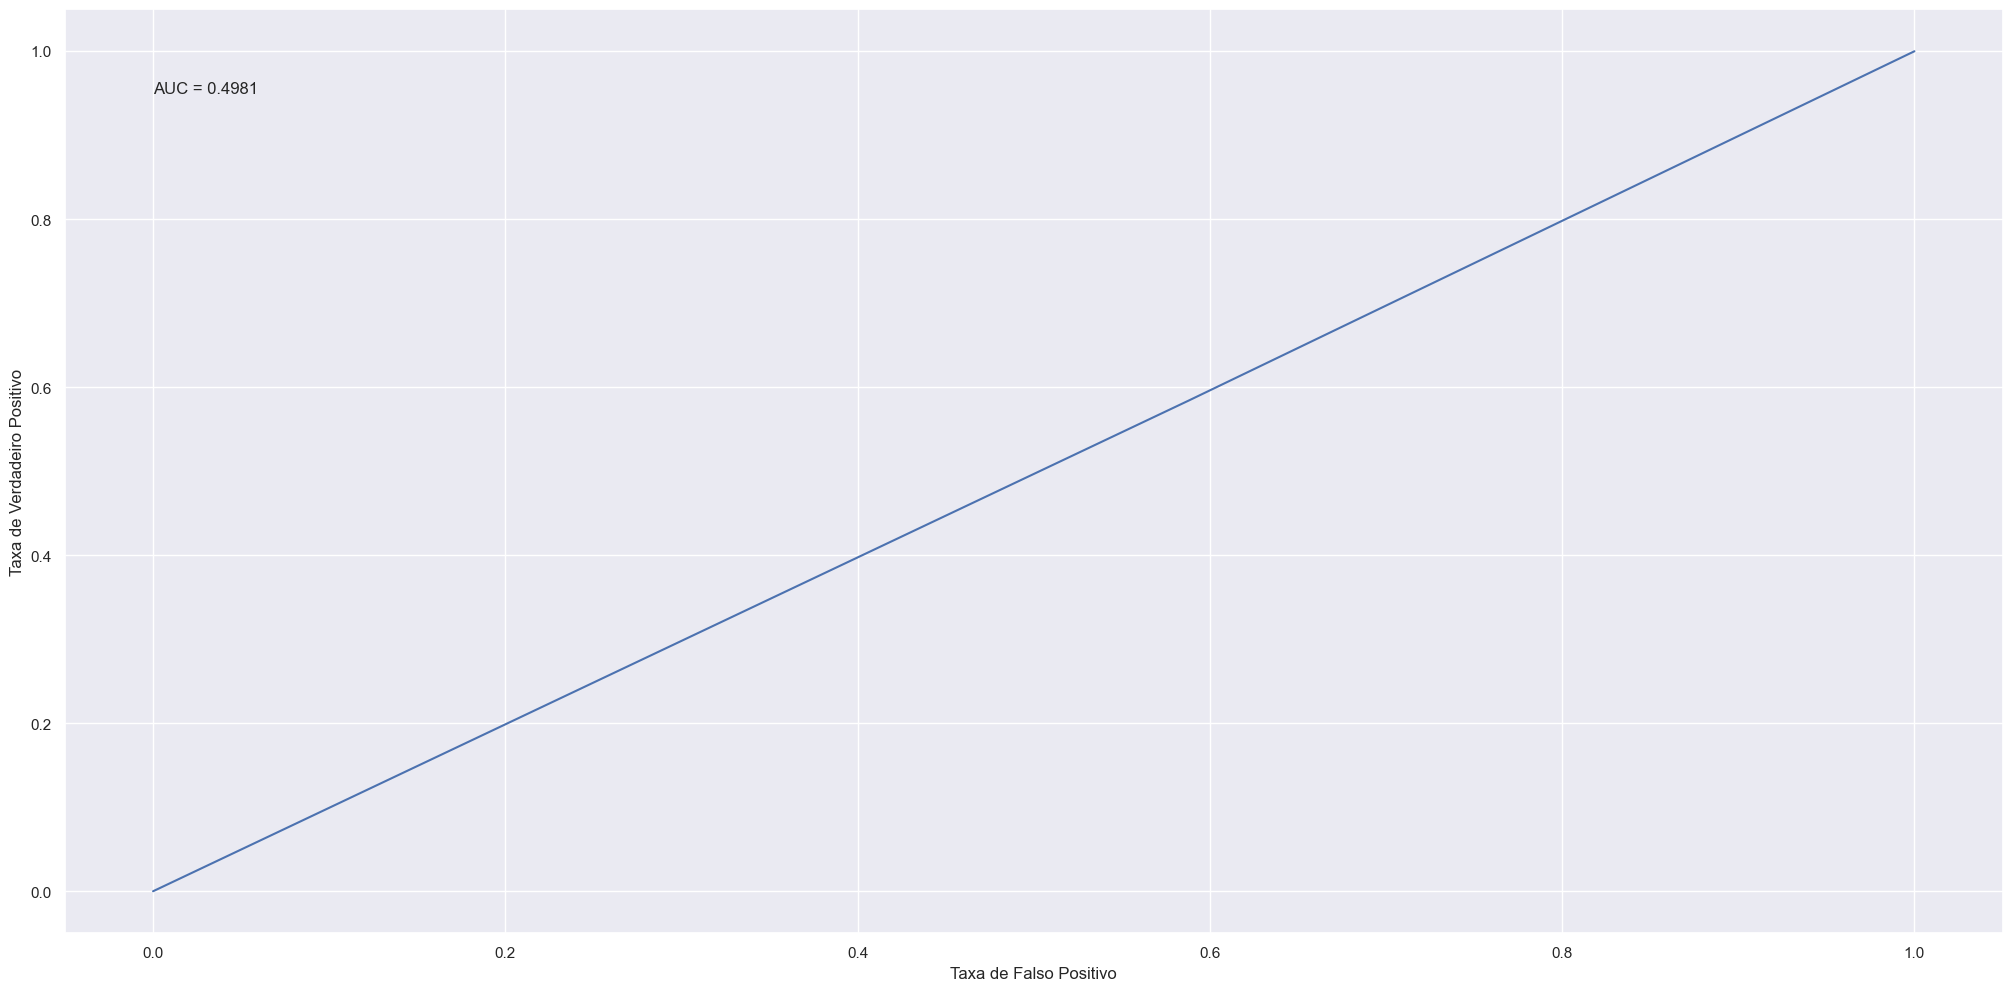

In [77]:
plt.plot(fpr, tpr)
plt.text(0.0, 0.95, "AUC = " + str(round(auc( fpr, tpr ),4)))
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.show();

In [78]:
thresholds

array([2, 1, 0])

In [79]:
clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 23, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 23, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


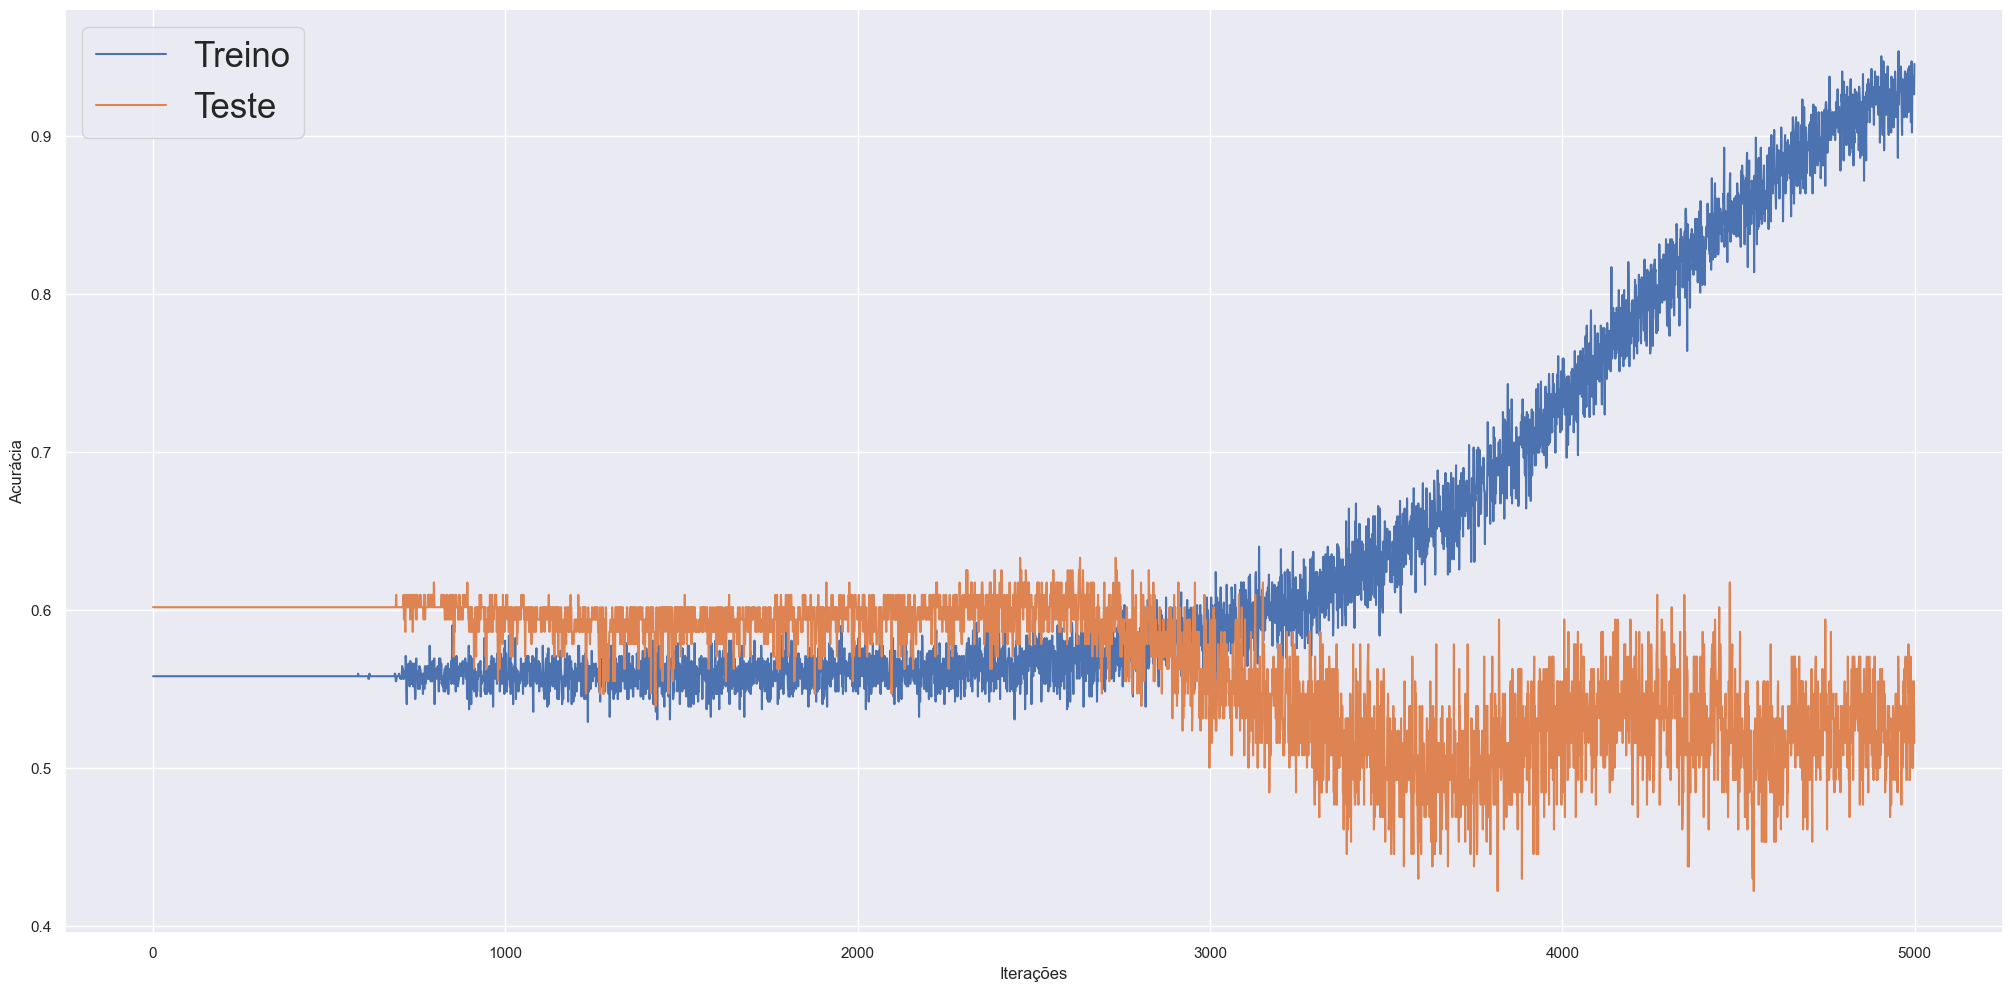

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Acurácia')
plt.xlabel('Iterações')
plt.legend(['Treino','Teste'], loc='upper left', prop={'size': 25})
plt.show;

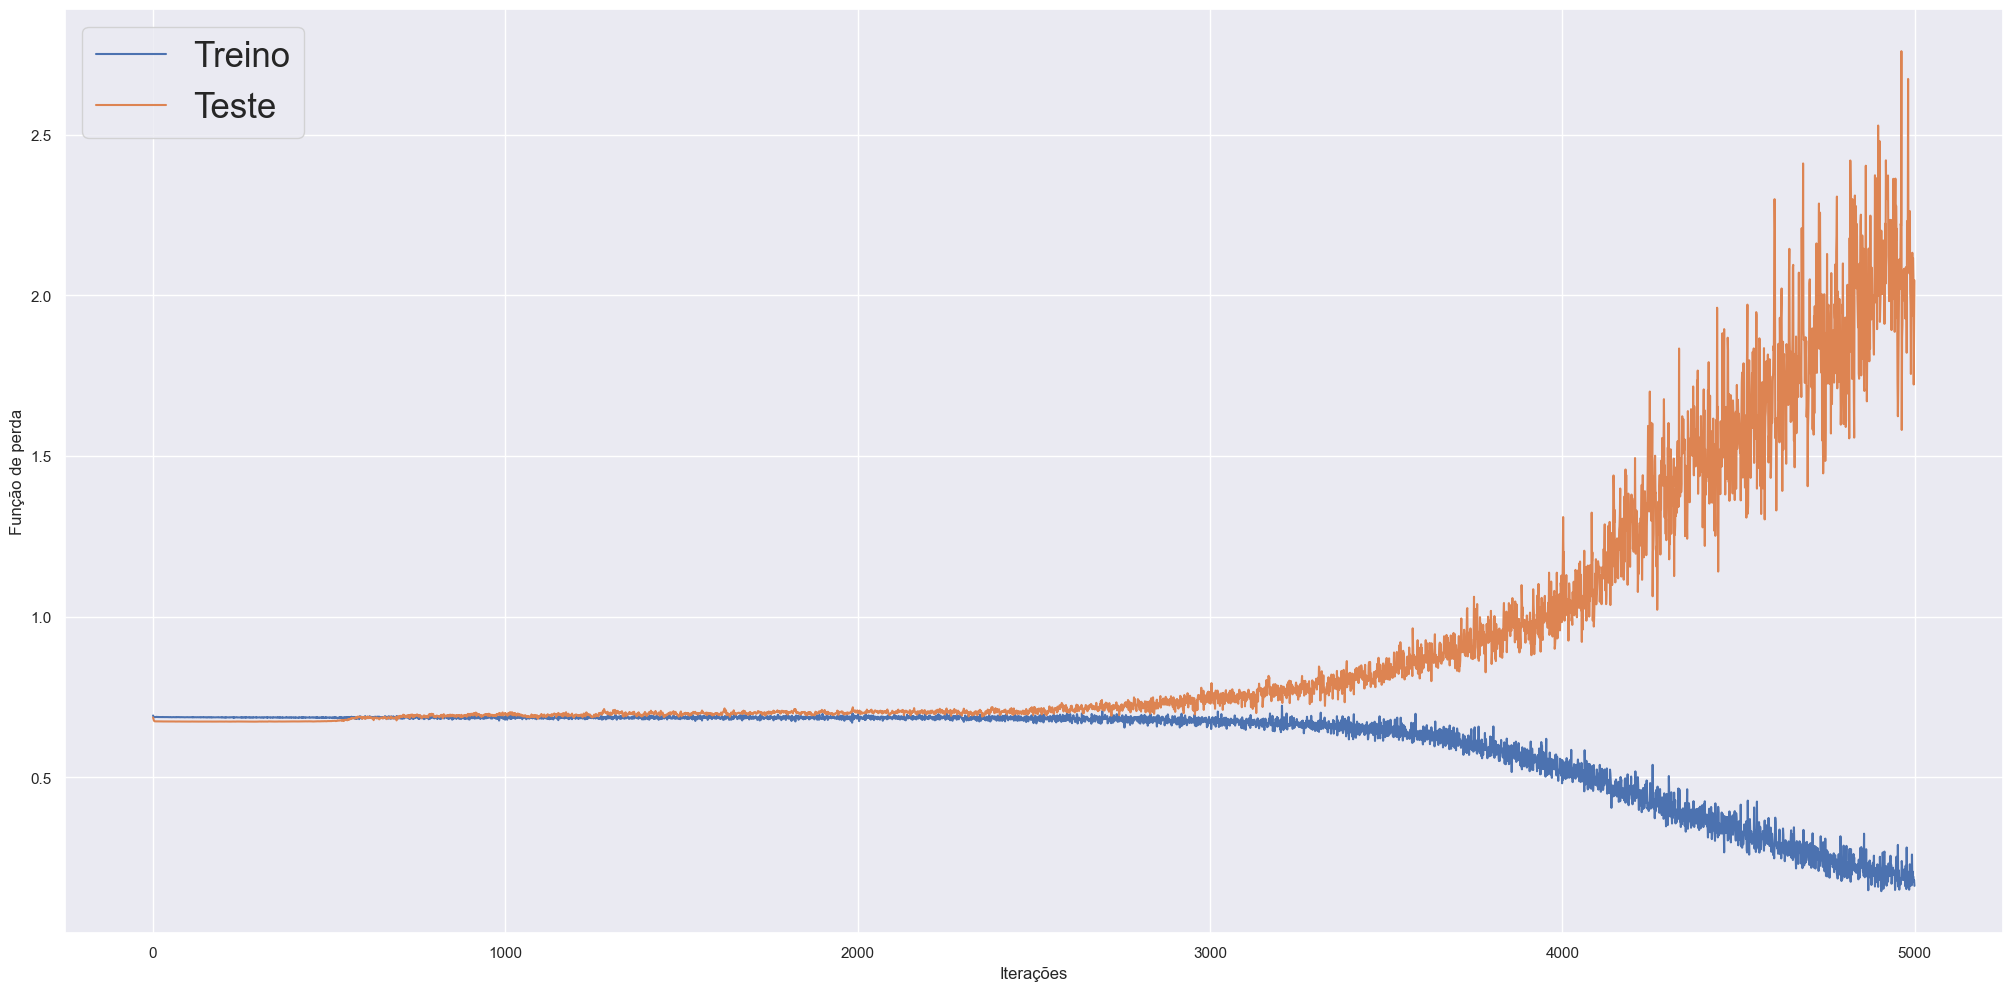

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Função de perda')
plt.xlabel('Iterações')
plt.legend(['Treino','Teste'], loc='upper left', prop={'size': 25})
plt.show;